# Imports

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

# Loading the data

In [2]:
# Load the data
df = pd.read_csv('data/match_alhambra_cosmos2020_ACS_class_0.8arcsec.csv')

# Load the ALHAMBRA catalog
# .cat files are typically space/whitespace delimited
alhambra_df = pd.read_csv('data/full_alhambra_V5_masksel_v6_head.cat', sep=r'\s+')

In [4]:
# Get column names from both dataframes
df_cols = set(df.columns)
alhambra_cols = set(alhambra_df.columns)

# Find columns unique to each dataframe
only_in_df = df_cols - alhambra_cols
only_in_alhambra = alhambra_cols - df_cols

print("Columns only in matched COSMOS df:")
for col in sorted(only_in_df):
    print(f"- {col}")
    
print("\nColumns only in ALHAMBRA df:")
for col in sorted(only_in_alhambra):
    print(f"- {col}")

# Check if COSMOS coordinates and IDs are in ALHAMBRA
cosmos_coords = ['Dec_1', 'RA_1', 'ID_1']
alhambra_coords = ['Dec', 'RA', '#ID']

print("Checking COSMOS coordinates in ALHAMBRA catalog:")
for cosmos_col, alhambra_col in zip(cosmos_coords, alhambra_coords):
    if cosmos_col in df.columns and alhambra_col in alhambra_df.columns:
        print(f"\n{cosmos_col} from COSMOS matches {alhambra_col} in ALHAMBRA")
        
        # Check if all COSMOS values exist in ALHAMBRA
        cosmos_vals = set(df[cosmos_col].dropna())
        alhambra_vals = set(alhambra_df[alhambra_col].dropna())
        
        overlap = cosmos_vals.intersection(alhambra_vals)
        
        print(f"COSMOS unique values: {len(cosmos_vals)}")
        print(f"ALHAMBRA unique values: {len(alhambra_vals)}")
        print(f"Overlapping values: {len(overlap)}")
        print(f"Percentage of COSMOS values in ALHAMBRA: {len(overlap)/len(cosmos_vals)*100:.2f}%")
    else:
        print(f"\nWarning: Could not compare {cosmos_col} with {alhambra_col}")
        print("One or both columns missing from datasets")


Columns only in matched COSMOS df:
- Dec_1
- ID_1
- RA_1
- Separation
- acs_f814w_mag
- acs_f814w_magerr
- acs_fwhm_world
- acs_mu_class
- acs_mu_max
- dec_2
- flag_hsc
- flag_supcam
- flag_udeep
- flag_uvista
- hsc_i_mag
- hsc_i_magerr
- hsc_i_valid
- hsc_r_mag
- hsc_r_magerr
- hsc_r_valid
- id_2
- model_flag
- ra_2
- solution_model
- uvista_j_mag
- uvista_j_magerr
- uvista_j_valid
- uvista_ks_mag
- uvista_ks_magerr
- uvista_ks_valid

Columns only in ALHAMBRA df:
- #ID
- Dec
- RA
Checking COSMOS coordinates in ALHAMBRA catalog:

Dec_1 from COSMOS matches Dec in ALHAMBRA
COSMOS unique values: 4765
ALHAMBRA unique values: 33569
Overlapping values: 4765
Percentage of COSMOS values in ALHAMBRA: 100.00%

RA_1 from COSMOS matches RA in ALHAMBRA
COSMOS unique values: 4753
ALHAMBRA unique values: 78585
Overlapping values: 4753
Percentage of COSMOS values in ALHAMBRA: 100.00%

ID_1 from COSMOS matches #ID in ALHAMBRA
COSMOS unique values: 27389
ALHAMBRA unique values: 378614
Overlapping values

## DEA COSMOS2020

This contains the possible training sample that we discussed to start with.
It is a cross-match between the previous ALHAMBRA catalog and the 
'COSMOS2020' catalog (the reference for this catalog is [1](https://ui.adsabs.harvard.edu/abs/2022ApJS..258...11W/abstract)).


Basically, the idea would be to use as a 'label' the class that is defined
in the last column ('acs_mu_class'), which defines a separation between
'star' (point source) and 'galaxy' (extended object), according to the
method described in section 3.6 of reference [2](https://ui.adsabs.harvard.edu/abs/2007ApJS..172..219L/abstract). 

This classification is based on very deep images (I think ~2-3 magnitudes
deeper than ALHAMBRA) taken with the HST's ACS camera (therefore from
space), so it can be a good reference. 

In this file, for the ~23000
matching objects, you have the same columns from the other file
corresponding to ALHAMBRA, and some additional columns that come from
COSMOS. In principle, these additional columns could not be used in the
classification, but they can be useful for verification if necessary.


Action Plan:
1. Data Preprocessing
   - Clean the data by handling NaN values
   - Normalize/scale numerical features
   - Encode categorical variables if needed
2. Feature Selection/Engineering
   - Identify most relevant ALHAMBRA features for classification
   - Create new features if beneficial
   - Remove highly correlated features
3. Model Development
   - Split data into train/validation/test sets
   - Try different classification algorithms (RF, SVM, etc.)
   - Perform hyperparameter tuning
   - Evaluate using metrics like accuracy, precision, recall
4. Model Validation
   - Cross-validation
   - Check for overfitting
   - Analyze misclassified cases
5. Final Testing & Documentation
   - Test on holdout set
   - Document model performance
   - Create visualizations of results


In [5]:
# Get basic information about the dataframe
print("DataFrame Shape:", df.shape)
print("\nDataFrame Info:")
df.info()

# Separate numerical and categorical columns
numerical_cols = df.select_dtypes(include=['int64', 'float64']).columns
categorical_cols = df.select_dtypes(include=['object', 'category']).columns

print("\nNumerical Columns:", len(numerical_cols))
print(numerical_cols.tolist())
print("\nCategorical Columns:", len(categorical_cols))
print(categorical_cols.tolist())

# Statistical summary of numerical columns
print("\nNumerical Columns Summary:")
print(df[numerical_cols].describe())

# Information about categorical columns
print("\nCategorical Columns Summary:")
for col in categorical_cols:
    print(f"\n{col}:")
    print(f"Number of unique categories: {df[col].nunique()}")
    print("All categories and their counts:")
    print(df[col].value_counts())

# NaN analysis
print("\nNaN Analysis:")
nan_counts = df.isna().sum()
print("\nColumns with NaN values:")
print(nan_counts[nan_counts > 0])

# Percentage of NaN values in each column
print("\nPercentage of NaN values in each column:")
print((df.isna().sum() / len(df) * 100)[nan_counts > 0])

# Find rows with NaN values
rows_with_nans = df[df.isna().any(axis=1)]
print(f"\nNumber of rows with at least one NaN: {len(rows_with_nans)}")

# Display first few rows with NaN values to understand the pattern
print("\nExample rows with NaN values:")
print(rows_with_nans.head())


name = 'photoflag'
# Analyze name column statistics
print(f"\n{name} Source Statistics:")
print("-" * 50)
print(f"Number of unique values: {df[name].nunique()}")
print("\nValue counts:")
print(df[name].value_counts())
print("\nDescriptive statistics:")
print(f"Mean: {df[name].mean():.4f}")
print(f"Median: {df[name].median():.4f}")
print(f"Mode: {df[name].mode()[0]}")
print(f"Standard deviation: {df[name].std():.4f}")
print("\nQuantiles:")
print(df[name].quantile([0.25, 0.5, 0.75]))



DataFrame Shape: (27389, 136)

DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27389 entries, 0 to 27388
Columns: 136 entries, ID_1 to Separation
dtypes: float64(116), int64(19), object(1)
memory usage: 28.4+ MB

Numerical Columns: 135
['ID_1', 'RA_1', 'Dec_1', 'x', 'y', 'area', 'fwhm', 'stell', 'ell', 'a', 'b', 'theta', 'rk', 'rf', 's2n', 'photoflag', 'F365W', 'dF365W', 'F396W', 'dF396W', 'F427W', 'dF427W', 'F458W', 'dF458W', 'F489W', 'dF489W', 'F520W', 'dF520W', 'F551W', 'dF551W', 'F582W', 'dF582W', 'F613W', 'dF613W', 'F644W', 'dF644W', 'F675W', 'dF675W', 'F706W', 'dF706W', 'F737W', 'dF737W', 'F768W', 'dF768W', 'F799W', 'dF799W', 'F830W', 'dF830W', 'F861W', 'dF861W', 'F892W', 'dF892W', 'F923W', 'dF923W', 'F954W', 'dF954W', 'J', 'dJ', 'H', 'dH', 'KS', 'dKS', 'F814W', 'dF814W', 'F814W_3arcs', 'dF814W_3arcs', 'F814W_3arcs_corr', 'nfobs', 'xray', 'PercW', 'Satur_Flag', 'Stellar_Flag', 'zb_1', 'zb_Min_1', 'zb_Max_1', 'Tb_1', 'Odds_1', 'z_ml', 't_ml', 'Chi2', 'Stell_Mass_

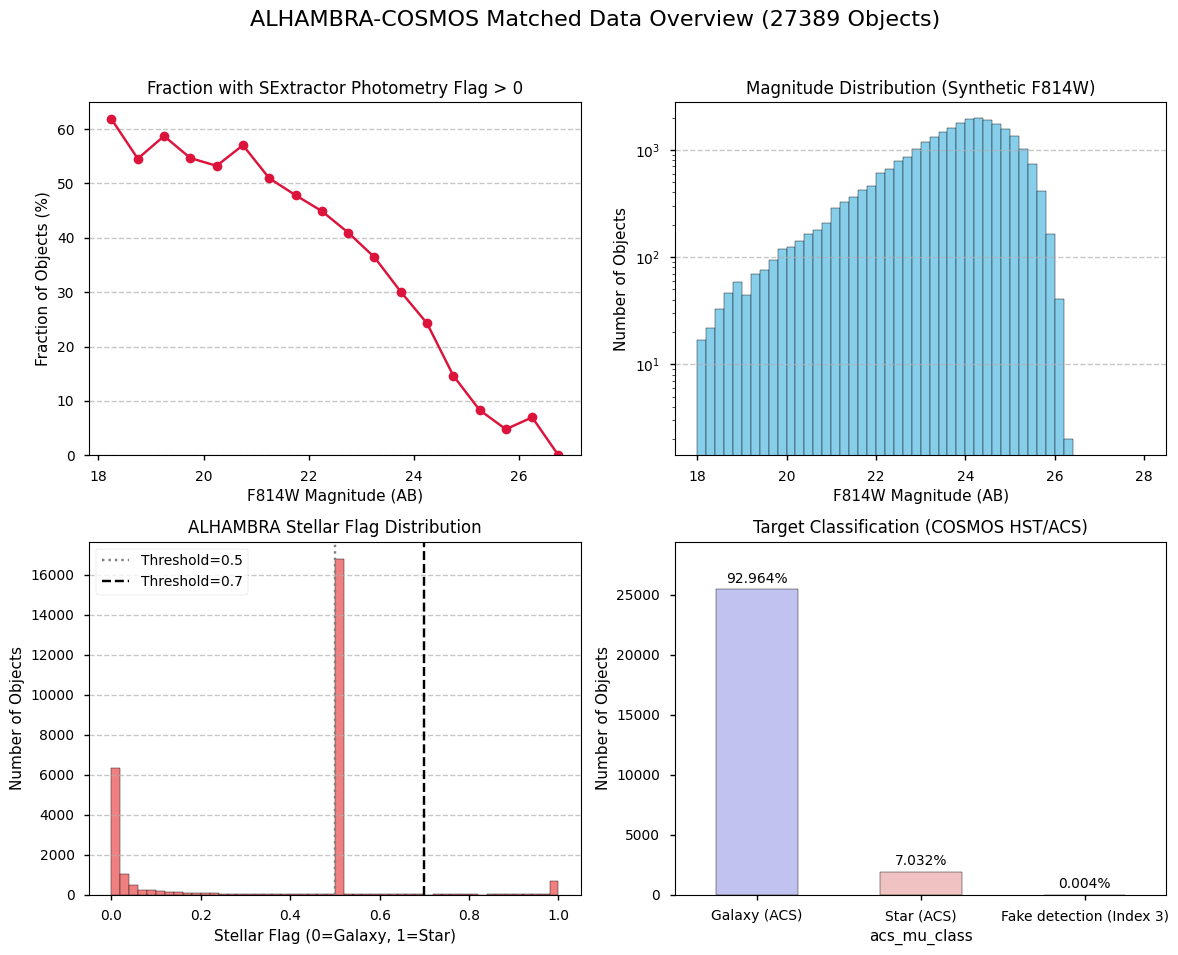


--- Summary Statistics for LaTeX ---
Total Matched Objects: 27389
Flagged SExtractor>0: 7906 (28.9%)
Flagged Saturated: 0 (0.0%)
ACS Classified Stars: 1926 (7.0%)
ACS Classified Galaxies: 25462 (93.0%)
ALHAMBRA Estimated Stars (Stellar_Flag > 0.7): 966
ALHAMBRA Estimated Galaxies (Stellar_Flag <= 0.7): 26423
-----------------------------------


In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Assuming 'df' is your pre-loaded DataFrame
# df = pd.read_csv('your_matched_file.csv') # Load if necessary

# --- Data Preparation & Calculations ---
total_objects = len(df)

# Basic Flag counts (for text)
flagged_photoflag_count = df[df['photoflag'] != 0].shape[0]
flagged_satur_count = df[df['Satur_Flag'] == 1].shape[0]
flagged_photoflag_perc = (flagged_photoflag_count / total_objects) * 100
flagged_satur_perc = (flagged_satur_count / total_objects) * 100

# ACS Classification counts (Target Label)
df['acs_mu_class'] = pd.to_numeric(df['acs_mu_class'], errors='coerce')
acs_counts = df['acs_mu_class'].value_counts().sort_index()
acs_labels = {2: 'Star (ACS)', 1: 'Galaxy (ACS)'}
acs_counts.index = acs_counts.index.map(lambda x: acs_labels.get(int(x), f'Fake detection (Index {int(x)})'))

# Filter out bad magnitude values
f814w_mags = df.loc[df['F814W'] < 90, 'F814W'].copy() # Use .copy() to avoid SettingWithCopyWarning
df_goodmag = df.loc[df['F814W'] < 90].copy()

# Calculate Flag Fraction vs Magnitude
mag_bins = np.arange(18, 27.5, 0.5) # Define magnitude bins
bin_centers = mag_bins[:-1] + 0.25

total_in_bin, _ = np.histogram(df_goodmag['F814W'], bins=mag_bins)
flagged_in_bin, _ = np.histogram(df_goodmag.loc[df_goodmag['photoflag'] != 0, 'F814W'], bins=mag_bins)

# Avoid division by zero if a bin is empty
flag_fraction = np.divide(flagged_in_bin, total_in_bin, out=np.zeros_like(flagged_in_bin, dtype=float), where=total_in_bin!=0)


# --- Plotting ---
plt.style.use('seaborn-v0_8-notebook')
fig, axs = plt.subplots(2, 2, figsize=(12, 10)) # Keep 2x2 layout
fig.suptitle(f'ALHAMBRA-COSMOS Matched Data Overview ({total_objects} Objects)', fontsize=16)

# Plot 1: SExtractor Flag Fraction vs Magnitude
axs[0, 0].plot(bin_centers, flag_fraction * 100, marker='o', linestyle='-', color='crimson')
axs[0, 0].set_title('Fraction with SExtractor Photometry Flag > 0')
axs[0, 0].set_xlabel('F814W Magnitude (AB)')
axs[0, 0].set_ylabel('Fraction of Objects (%)')
axs[0, 0].set_ylim(bottom=0) # Start y-axis at 0
axs[0, 0].grid(axis='y', linestyle='--', alpha=0.7)

# Plot 2: Magnitude Distribution (Unchanged)
axs[0, 1].hist(f814w_mags, bins=50, color='skyblue', edgecolor='black', range=(18, 28))
axs[0, 1].set_title('Magnitude Distribution (Synthetic F814W)')
axs[0, 1].set_xlabel('F814W Magnitude (AB)')
axs[0, 1].set_ylabel('Number of Objects')
axs[0, 1].set_yscale('log')
axs[0, 1].grid(axis='y', linestyle='--', alpha=0.7)

# Plot 3: ALHAMBRA Star/Galaxy Classifier Distribution (Unchanged)
axs[1, 0].hist(df['Stellar_Flag'], bins=50, color='lightcoral', edgecolor='black')
axs[1, 0].set_title('ALHAMBRA Stellar Flag Distribution')
axs[1, 0].set_xlabel('Stellar Flag (0=Galaxy, 1=Star)')
axs[1, 0].set_ylabel('Number of Objects')
axs[1, 0].axvline(0.5, color='grey', linestyle=':', label='Threshold=0.5')
axs[1, 0].axvline(0.7, color='black', linestyle='--', label='Threshold=0.7')
axs[1, 0].legend()
axs[1, 0].grid(axis='y', linestyle='--', alpha=0.7)

# Plot 4: COSMOS ACS Classification Distribution (Target Label) (Unchanged)
acs_counts.plot(kind='bar', ax=axs[1, 1], color=['#c2c2f0','#f0c2c2'], edgecolor='black')
axs[1, 1].set_title('Target Classification (COSMOS HST/ACS)')
axs[1, 1].set_ylabel('Number of Objects')
axs[1, 1].tick_params(axis='x', rotation=0)
# Make y axis 20% taller
y_max = axs[1, 1].get_ylim()[1]
axs[1, 1].set_ylim(top=y_max * 1.1)
acs_perc = [(count / total_objects) * 100 for count in acs_counts]
for i, perc in enumerate(acs_perc):
    axs[1, 1].text(i, acs_counts.iloc[i] + 0.01 * total_objects, f'{perc:.3f}%',
                   ha='center', va='bottom')

# --- Final Touches ---
plt.tight_layout(rect=[0, 0.03, 1, 0.96])
plt.show()

# --- Generate Summary Statistics for LaTeX (excluding duplicate count now) ---
acs_stars = acs_counts.get('Star (ACS)', 0)
acs_galaxies = acs_counts.get('Galaxy (ACS)', 0)
alh_stars_est = df[df['Stellar_Flag'] > 0.7].shape[0]
alh_galaxies_est = df[df['Stellar_Flag'] <= 0.7].shape[0]

print("\n--- Summary Statistics for LaTeX ---")
print(f"Total Matched Objects: {total_objects}")
print(f"Flagged SExtractor>0: {flagged_photoflag_count} ({flagged_photoflag_perc:.1f}%)")
print(f"Flagged Saturated: {flagged_satur_count} ({flagged_satur_perc:.1f}%)")
print(f"ACS Classified Stars: {acs_stars} ({acs_stars/total_objects*100:.1f}%)")
print(f"ACS Classified Galaxies: {acs_galaxies} ({acs_galaxies/total_objects*100:.1f}%)")
print(f"ALHAMBRA Estimated Stars (Stellar_Flag > 0.7): {alh_stars_est}")
print(f"ALHAMBRA Estimated Galaxies (Stellar_Flag <= 0.7): {alh_galaxies_est}")
print("-" * 35)

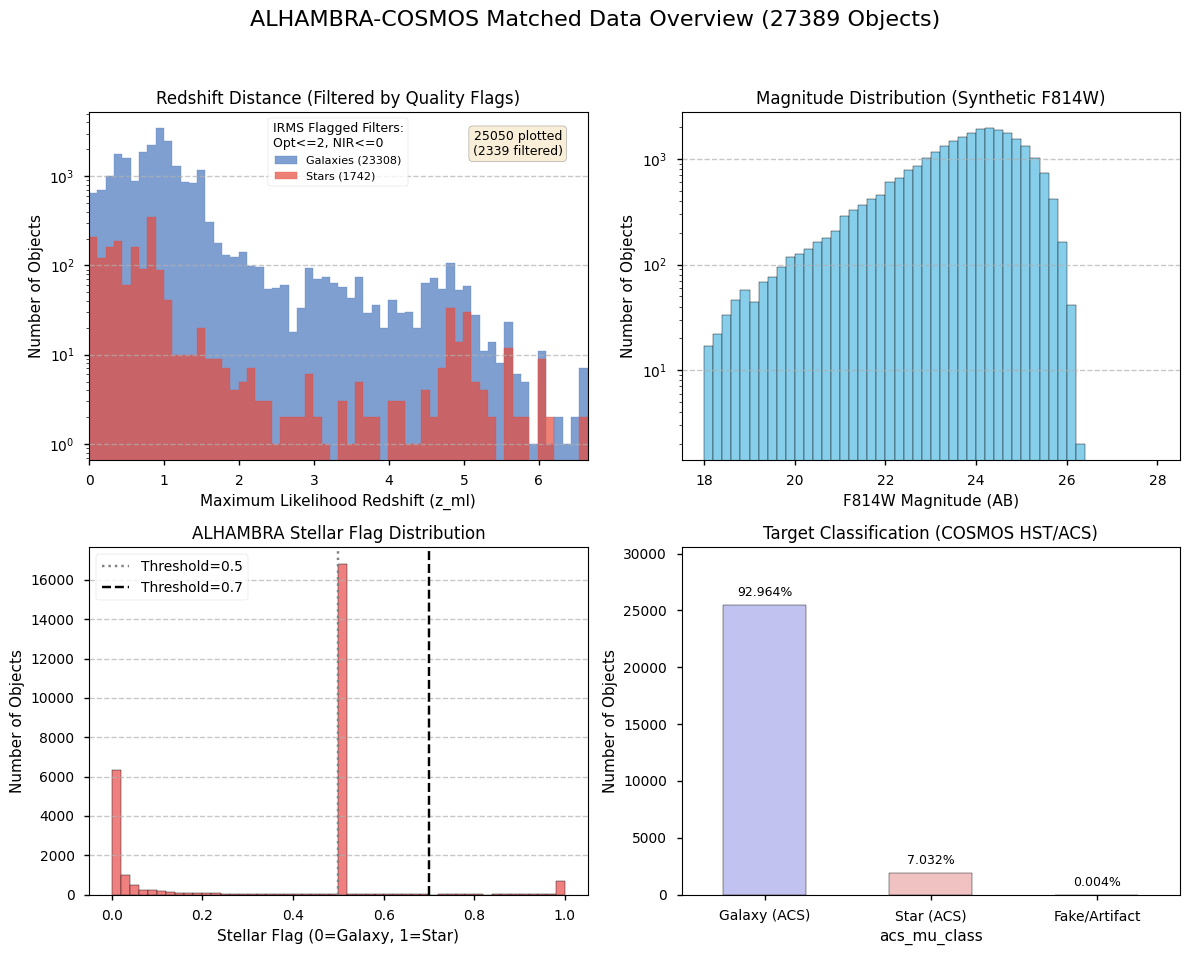


--- Summary Statistics for LaTeX ---
Total Matched Objects: 27389
Flagged SExtractor>0: 7906 (28.9%)
Flagged Saturated: 0 (0.0%)
ACS Classified Stars (Initial): 1926 (7.0%)
ACS Classified Galaxies (Initial): 25462 (93.0%)
ALHAMBRA Estimated Stars (Stellar_Flag > 0.7): 966
ALHAMBRA Estimated Galaxies (Stellar_Flag <= 0.7): 26423
-----------------------------------
Redshift Plot Filtering Criteria:
  - Class: Star (2) or Galaxy (1)
  - z_ml: 0.0 <= z < 12.0
  - irms_OPT_Flag <= 2
  - irms_NIR_Flag <= 0
Objects plotted in Z hist (after flag filtering): 25050
  - Plotted Galaxies: 23308
  - Plotted Stars: 1742
Objects filtered from Z hist (bad Z, class, or flags): 2339 (8.5%)
-----------------------------------


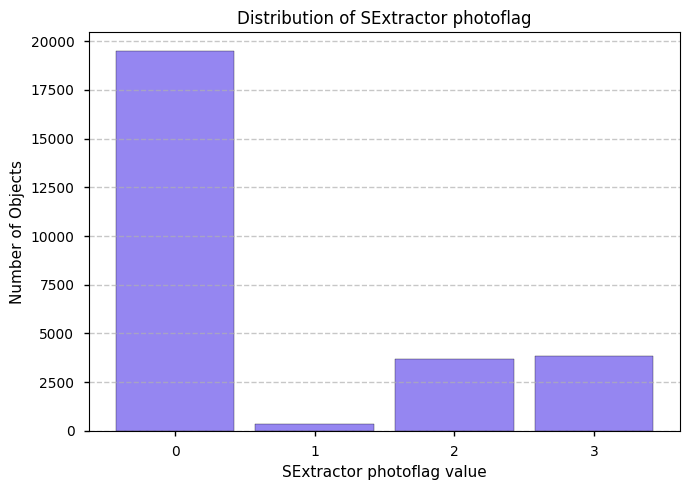

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# --- Configuration ---
Z_ML_COLUMN = 'z_ml'
ACS_CLASS_COLUMN = 'acs_mu_class'
IRMS_OPT_FLAG_COL = 'irms_OPT_Flag' # Column for optical flags
IRMS_NIR_FLAG_COL = 'irms_NIR_Flag' # Column for NIR flags

GALAXY_CLASS_ID = 1
STAR_CLASS_ID = 2

# Filtering Thresholds
MAX_ACCEPTABLE_OPT_FLAG = 2 # Max allowed value for irms_OPT_Flag
MAX_ACCEPTABLE_NIR_FLAG = 0 # Max allowed value for irms_NIR_Flag
Z_MIN = 0.0 # Minimum plausible redshift
Z_MAX_FILTER = 12.0 # Absolute upper limit for z_ml (filter out extreme outliers)

# Plotting Parameters
Z_MAX_PLOT = df[Z_ML_COLUMN].max() # Max redshift to display in the histogram plot
N_BINS_Z = 60
PLOT_STYLE = 'seaborn-v0_8-notebook'
GALAXY_COLOR = '#4B77BE' # Rich Royal Blue
STAR_COLOR = '#E74C3C' # Vibrant Coral Red
HIST_ALPHA = 0.7

# --- Load Data (Assuming 'df' is pre-loaded) ---
# Example: df = pd.read_csv('your_matched_file.csv')
if 'df' not in locals() or df is None:
    print("Warning: DataFrame 'df' not found. Creating dummy data for testing.")
    _n_dummy = 5000
    df = pd.DataFrame({
        'photoflag': np.random.choice([0, 1, 2, 4], size=_n_dummy, p=[0.7, 0.1, 0.1, 0.1]),
        'Satur_Flag': np.random.choice([0, 1], size=_n_dummy, p=[0.995, 0.005]),
        ACS_CLASS_COLUMN: np.random.choice([GALAXY_CLASS_ID, STAR_CLASS_ID, 3], size=_n_dummy, p=[0.90, 0.09, 0.01]),
        'F814W': np.random.normal(24, 1.5, size=_n_dummy),
        Z_ML_COLUMN: np.abs(np.random.normal(1.5, 1.0, size=_n_dummy)),
        'Stellar_Flag': np.random.beta(2, 2, size=_n_dummy),
        IRMS_OPT_FLAG_COL: np.random.choice([0, 1, 2, 3, 4, 5, 10], size=_n_dummy, p=[0.8, 0.08, 0.05, 0.03, 0.02, 0.01, 0.01]),
        IRMS_NIR_FLAG_COL: np.random.choice([0, 1, 2, 3], size=_n_dummy, p=[0.9, 0.05, 0.03, 0.02]),
    })
    # Make stars have low redshift in dummy data
    df.loc[df[ACS_CLASS_COLUMN] == STAR_CLASS_ID, Z_ML_COLUMN] = np.abs(np.random.normal(0.01, 0.005, df[df[ACS_CLASS_COLUMN] == STAR_CLASS_ID].shape[0]))
    # Introduce some high-z values for galaxies
    high_z_indices = df[df[ACS_CLASS_COLUMN] == GALAXY_CLASS_ID].sample(frac=0.1).index
    df.loc[high_z_indices, Z_ML_COLUMN] = np.random.uniform(4, 7, size=len(high_z_indices))
    # Introduce some bad flags linked to high z
    bad_flag_indices = df[df[Z_ML_COLUMN] > 3].sample(frac=0.3).index
    df.loc[bad_flag_indices, IRMS_OPT_FLAG_COL] = np.random.choice([5, 6, 7, 8, 9, 10, 11], size=len(bad_flag_indices))
    df.loc[bad_flag_indices, IRMS_NIR_FLAG_COL] = np.random.choice([2, 3], size=len(bad_flag_indices))


total_objects = len(df)

# --- Data Preparation & Calculations ---

# Check necessary columns exist
required_cols = [Z_ML_COLUMN, ACS_CLASS_COLUMN, IRMS_OPT_FLAG_COL, IRMS_NIR_FLAG_COL, 'photoflag', 'Satur_Flag', 'F814W', 'Stellar_Flag']
for col in required_cols:
    if col not in df.columns:
        raise KeyError(f"Required column '{col}' not found in DataFrame.")

# Basic Flag counts (for text) - Unchanged
flagged_photoflag_count = df[df['photoflag'] != 0].shape[0]
flagged_satur_count = df[df['Satur_Flag'] == 1].shape[0]
flagged_photoflag_perc = (flagged_photoflag_count / total_objects) * 100
flagged_satur_perc = (flagged_satur_count / total_objects) * 100

# ACS Classification counts (Target Label) - Unchanged logic
df[ACS_CLASS_COLUMN] = pd.to_numeric(df[ACS_CLASS_COLUMN], errors='coerce')
df_cleaned_acs = df.dropna(subset=[ACS_CLASS_COLUMN]).copy()
df_cleaned_acs[ACS_CLASS_COLUMN] = df_cleaned_acs[ACS_CLASS_COLUMN].astype(int)
acs_counts = df_cleaned_acs[ACS_CLASS_COLUMN].value_counts().sort_index()
acs_labels = {GALAXY_CLASS_ID: 'Galaxy (ACS)', STAR_CLASS_ID: 'Star (ACS)', 3: 'Fake/Artifact'}
acs_counts.index = acs_counts.index.map(lambda x: acs_labels.get(x, f'Other ({x})'))

# Filter out bad magnitude values - Unchanged
f814w_mags = df.loc[df['F814W'] < 90, 'F814W'].copy()

# --- REVISED: Prepare Redshift Data using Flag Filtering ---

# Convert potentially relevant columns to numeric, coercing errors
z_ml_values = pd.to_numeric(df[Z_ML_COLUMN], errors='coerce')
class_values = pd.to_numeric(df[ACS_CLASS_COLUMN], errors='coerce') # Already done, but safe to repeat
opt_flag_values = pd.to_numeric(df[IRMS_OPT_FLAG_COL], errors='coerce')
nir_flag_values = pd.to_numeric(df[IRMS_NIR_FLAG_COL], errors='coerce')

# Create boolean masks for filtering conditions
# 1. Valid class (Star or Galaxy)
valid_class_mask = class_values.isin([GALAXY_CLASS_ID, STAR_CLASS_ID])
# 2. Valid redshift value (non-NaN, within reasonable physical bounds)
valid_z_mask = z_ml_values.notna() & (z_ml_values >= Z_MIN) & (z_ml_values < Z_MAX_FILTER)
# 3. Acceptable optical flag value (non-NaN and below threshold)
valid_opt_flag_mask = opt_flag_values.notna() & (opt_flag_values <= MAX_ACCEPTABLE_OPT_FLAG)
# 4. Acceptable NIR flag value (non-NaN and below threshold)
valid_nir_flag_mask = nir_flag_values.notna() & (nir_flag_values <= MAX_ACCEPTABLE_NIR_FLAG)

# Combine all masks
valid_mask_combined = valid_class_mask & valid_z_mask & valid_opt_flag_mask & valid_nir_flag_mask

# Filter the DataFrame to keep only objects passing all criteria
df_filtered_z_class = df.loc[valid_mask_combined].copy()

# Separate redshift values by class from the *filtered* DataFrame
z_ml_galaxies = df_filtered_z_class.loc[df_filtered_z_class[ACS_CLASS_COLUMN] == GALAXY_CLASS_ID, Z_ML_COLUMN]
z_ml_stars = df_filtered_z_class.loc[df_filtered_z_class[ACS_CLASS_COLUMN] == STAR_CLASS_ID, Z_ML_COLUMN]

num_plotted_total = len(df_filtered_z_class)
num_filtered_out = total_objects - num_plotted_total


# --- Plotting ---
plt.style.use(PLOT_STYLE)
fig, axs = plt.subplots(2, 2, figsize=(12, 10))
fig.suptitle(f'ALHAMBRA-COSMOS Matched Data Overview ({total_objects} Objects)', fontsize=16)

# --- Plot 1 (REVISED): Redshift Distribution by Class (Filtered by Flags) ---
# Plot galaxies
axs[0, 0].hist(z_ml_galaxies, bins=N_BINS_Z, range=(Z_MIN, Z_MAX_PLOT),
               color=GALAXY_COLOR, alpha=HIST_ALPHA, label=f'Galaxies ({len(z_ml_galaxies)})', histtype='stepfilled', edgecolor=GALAXY_COLOR)
# Plot stars
axs[0, 0].hist(z_ml_stars, bins=N_BINS_Z, range=(Z_MIN, Z_MAX_PLOT),
               color=STAR_COLOR, alpha=HIST_ALPHA, label=f'Stars ({len(z_ml_stars)})', histtype='stepfilled', edgecolor=STAR_COLOR)

axs[0, 0].set_title(f'Redshift Distance (Filtered by Quality Flags)')
axs[0, 0].set_xlabel(f'Maximum Likelihood Redshift ({Z_ML_COLUMN})')
axs[0, 0].set_ylabel('Number of Objects')
axs[0, 0].set_yscale('log')
axs[0, 0].set_xlim(Z_MIN, Z_MAX_PLOT)
axs[0, 0].grid(axis='y', linestyle='--', alpha=0.7)
axs[0, 0].legend(title=f"IRMS Flagged Filters:\nOpt<={MAX_ACCEPTABLE_OPT_FLAG}, NIR<={MAX_ACCEPTABLE_NIR_FLAG}", fontsize=8, title_fontsize=9)

# Add text indicating number of objects filtered out
if num_filtered_out > 0:
     axs[0, 0].text(0.95, 0.95, f'{num_plotted_total} plotted\n({num_filtered_out} filtered)',
                    ha='right', va='top', transform=axs[0, 0].transAxes, fontsize=9,
                    bbox=dict(boxstyle='round,pad=0.3', fc='wheat', alpha=0.5))


# Plot 2: Magnitude Distribution (Unchanged - shows original distribution)
axs[0, 1].hist(f814w_mags, bins=50, color='skyblue', edgecolor='black', range=(18, 28))
axs[0, 1].set_title('Magnitude Distribution (Synthetic F814W)')
axs[0, 1].set_xlabel('F814W Magnitude (AB)')
axs[0, 1].set_ylabel('Number of Objects')
axs[0, 1].set_yscale('log')
axs[0, 1].grid(axis='y', linestyle='--', alpha=0.7)

# Plot 3: ALHAMBRA Star/Galaxy Classifier Distribution (Unchanged - shows original distribution)
stellar_flag_numeric = pd.to_numeric(df['Stellar_Flag'], errors='coerce')
stellar_flag_filtered = stellar_flag_numeric.dropna()
axs[1, 0].hist(stellar_flag_filtered, bins=50, color='lightcoral', edgecolor='black', range=(0,1))
axs[1, 0].set_title('ALHAMBRA Stellar Flag Distribution')
axs[1, 0].set_xlabel('Stellar Flag (0=Galaxy, 1=Star)')
axs[1, 0].set_ylabel('Number of Objects')
axs[1, 0].axvline(0.5, color='grey', linestyle=':', label='Threshold=0.5')
axs[1, 0].axvline(0.7, color='black', linestyle='--', label='Threshold=0.7')
axs[1, 0].legend()
axs[1, 0].grid(axis='y', linestyle='--', alpha=0.7)

# Plot 4: COSMOS ACS Classification Distribution (Target Label) (Unchanged plotting part)
if not acs_counts.empty:
    ordered_labels = ['Galaxy (ACS)', 'Star (ACS)', 'Fake/Artifact']
    plot_counts = acs_counts.reindex(ordered_labels).fillna(0)
    plot_counts.plot(kind='bar', ax=axs[1, 1], color=['#c2c2f0', '#f0c2c2', '#d3d3d3'], edgecolor='black')
    axs[1, 1].set_title('Target Classification (COSMOS HST/ACS)')
    axs[1, 1].set_ylabel('Number of Objects')
    axs[1, 1].set_xlabel('acs_mu_class')
    axs[1, 1].tick_params(axis='x', rotation=0)
    y_max = plot_counts.max()
    axs[1, 1].set_ylim(top=y_max * 1.2)
    total_original_objects_for_perc = total_objects
    acs_perc = [(count / total_original_objects_for_perc) * 100 for count in plot_counts]
    for i, (count, perc) in enumerate(zip(plot_counts, acs_perc)):
        axs[1, 1].text(i, count + 0.02 * y_max, f'{perc:.3f}%',
                       ha='center', va='bottom', fontsize=9)
else:
    axs[1, 1].text(0.5, 0.5, 'No ACS class data found/plotted', ha='center', va='center')
    axs[1, 1].set_title('Target Classification (COSMOS HST/ACS)')

# --- Final Touches ---
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

# --- Generate Summary Statistics for LaTeX (Add info about flag filtering) ---
acs_stars = acs_counts.get('Star (ACS)', 0)
acs_galaxies = acs_counts.get('Galaxy (ACS)', 0)
alh_stars_est = stellar_flag_numeric[stellar_flag_numeric > 0.7].count()
alh_galaxies_est = stellar_flag_numeric[stellar_flag_numeric <= 0.7].count()

print("\n--- Summary Statistics for LaTeX ---")
print(f"Total Matched Objects: {total_objects}")
print(f"Flagged SExtractor>0: {flagged_photoflag_count} ({flagged_photoflag_perc:.1f}%)")
print(f"Flagged Saturated: {flagged_satur_count} ({flagged_satur_perc:.1f}%)")
print(f"ACS Classified Stars (Initial): {acs_stars} ({acs_stars/total_objects*100:.1f}%)")
print(f"ACS Classified Galaxies (Initial): {acs_galaxies} ({acs_galaxies/total_objects*100:.1f}%)")
print(f"ALHAMBRA Estimated Stars (Stellar_Flag > 0.7): {alh_stars_est}")
print(f"ALHAMBRA Estimated Galaxies (Stellar_Flag <= 0.7): {alh_galaxies_est}")
print("-" * 35)
print(f"Redshift Plot Filtering Criteria:")
print(f"  - Class: Star ({STAR_CLASS_ID}) or Galaxy ({GALAXY_CLASS_ID})")
print(f"  - {Z_ML_COLUMN}: {Z_MIN} <= z < {Z_MAX_FILTER}")
print(f"  - {IRMS_OPT_FLAG_COL} <= {MAX_ACCEPTABLE_OPT_FLAG}")
print(f"  - {IRMS_NIR_FLAG_COL} <= {MAX_ACCEPTABLE_NIR_FLAG}")
print(f"Objects plotted in Z hist (after flag filtering): {num_plotted_total}")
print(f"  - Plotted Galaxies: {len(z_ml_galaxies)}")
print(f"  - Plotted Stars: {len(z_ml_stars)}")
print(f"Objects filtered from Z hist (bad Z, class, or flags): {num_filtered_out} ({num_filtered_out/total_objects*100:.1f}%)")
print("-" * 35)

# --- Additional Figure: Histogram of SExtractor photoflag ---
plt.figure(figsize=(7, 5))
photoflag_values = df['photoflag'].dropna()
unique_flags = np.sort(photoflag_values.unique())
plt.hist(photoflag_values, bins=np.arange(photoflag_values.min()-0.5, photoflag_values.max()+1.5, 1), 
         color='mediumslateblue', edgecolor='black', alpha=0.8, rwidth=0.85)
plt.xlabel('SExtractor photoflag value')
plt.ylabel('Number of Objects')
plt.title('Distribution of SExtractor photoflag')
plt.xticks(unique_flags)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

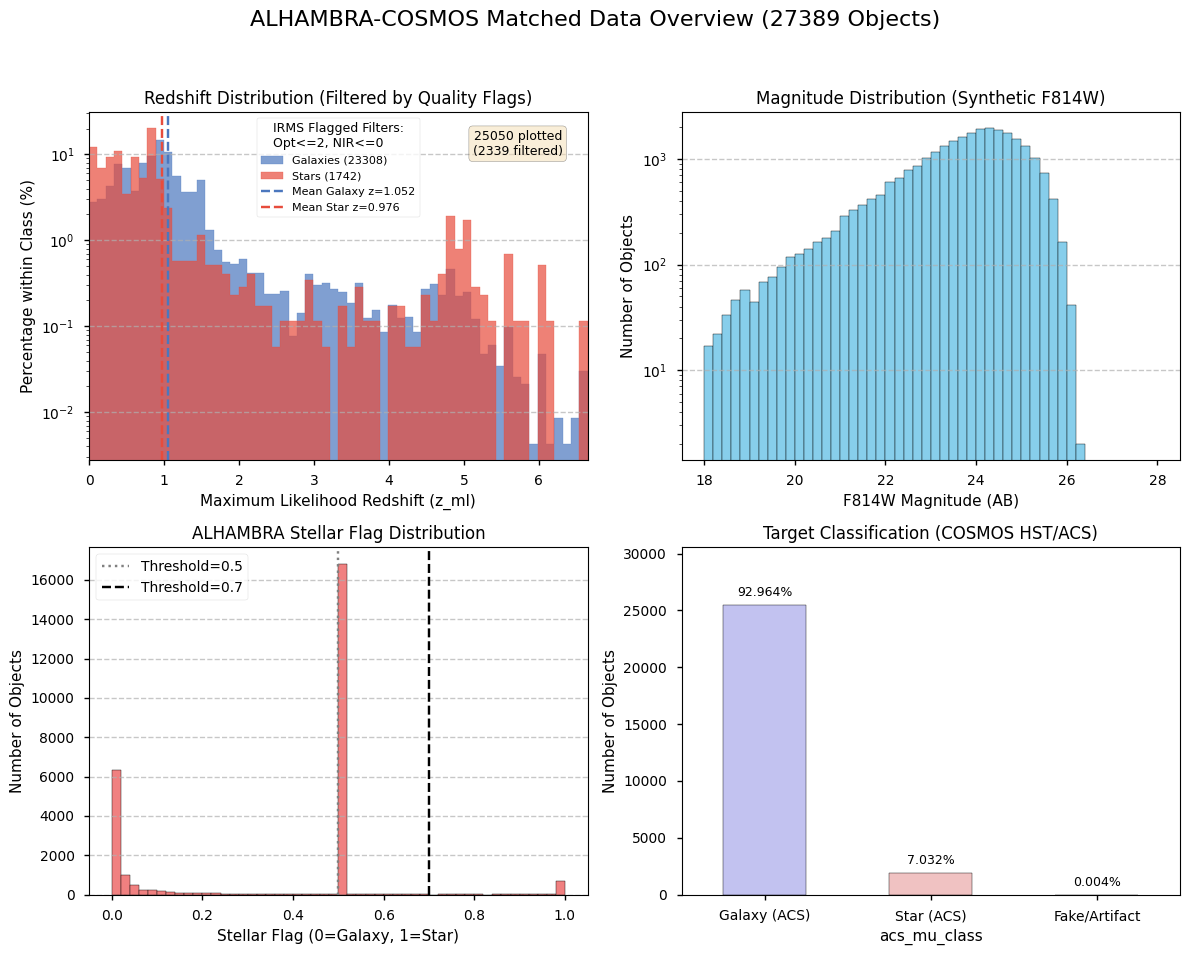


--- Summary Statistics for LaTeX ---
Total Matched Objects: 27389
Flagged SExtractor>0: 7906 (28.9%)
Flagged Saturated: 0 (0.0%)
ACS Classified Stars (Initial): 1926 (7.0%)
ACS Classified Galaxies (Initial): 25462 (93.0%)
ALHAMBRA Estimated Stars (Stellar_Flag > 0.7): 966
ALHAMBRA Estimated Galaxies (Stellar_Flag <= 0.7): 26423
-----------------------------------
Redshift Plot Filtering Criteria:
  - Class: Star (2) or Galaxy (1)
  - z_ml: 0.0 <= z < 12.0
  - irms_OPT_Flag <= 2
  - irms_NIR_Flag <= 0
Objects plotted in Z hist (after flag filtering): 25050
  - Plotted Galaxies: 23308
  - Plotted Stars: 1742
Objects filtered from Z hist (bad Z, class, or flags): 2339 (8.5%)
-----------------------------------


In [24]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# --- Configuration ---
Z_ML_COLUMN = 'z_ml'
ACS_CLASS_COLUMN = 'acs_mu_class'
IRMS_OPT_FLAG_COL = 'irms_OPT_Flag' # Column for optical flags
IRMS_NIR_FLAG_COL = 'irms_NIR_Flag' # Column for NIR flags

GALAXY_CLASS_ID = 1
STAR_CLASS_ID = 2

# Filtering Thresholds
MAX_ACCEPTABLE_OPT_FLAG = 2 # Max allowed value for irms_OPT_Flag
MAX_ACCEPTABLE_NIR_FLAG = 0 # Max allowed value for irms_NIR_Flag
Z_MIN = 0.0 # Minimum plausible redshift
Z_MAX_FILTER = 12.0 # Absolute upper limit for z_ml (filter out extreme outliers)

# Plotting Parameters
Z_MAX_PLOT = df[Z_ML_COLUMN].max() # Max redshift to display in the histogram plot
N_BINS_Z = 60
PLOT_STYLE = 'seaborn-v0_8-notebook'
GALAXY_COLOR = '#4B77BE' # Rich Royal Blue
STAR_COLOR = '#E74C3C' # Vibrant Coral Red
HIST_ALPHA = 0.7

# --- Load Data (Assuming 'df' is pre-loaded) ---
# Example: df = pd.read_csv('your_matched_file.csv')
if 'df' not in locals() or df is None:
    print("Warning: DataFrame 'df' not found. Creating dummy data for testing.")
    _n_dummy = 5000
    df = pd.DataFrame({
        'photoflag': np.random.choice([0, 1, 2, 4], size=_n_dummy, p=[0.7, 0.1, 0.1, 0.1]),
        'Satur_Flag': np.random.choice([0, 1], size=_n_dummy, p=[0.995, 0.005]),
        ACS_CLASS_COLUMN: np.random.choice([GALAXY_CLASS_ID, STAR_CLASS_ID, 3], size=_n_dummy, p=[0.90, 0.09, 0.01]),
        'F814W': np.random.normal(24, 1.5, size=_n_dummy),
        Z_ML_COLUMN: np.abs(np.random.normal(1.5, 1.0, size=_n_dummy)),
        'Stellar_Flag': np.random.beta(2, 2, size=_n_dummy),
        IRMS_OPT_FLAG_COL: np.random.choice([0, 1, 2, 3, 4, 5, 10], size=_n_dummy, p=[0.8, 0.08, 0.05, 0.03, 0.02, 0.01, 0.01]),
        IRMS_NIR_FLAG_COL: np.random.choice([0, 1, 2, 3], size=_n_dummy, p=[0.9, 0.05, 0.03, 0.02]),
    })
    # Make stars have low redshift in dummy data
    df.loc[df[ACS_CLASS_COLUMN] == STAR_CLASS_ID, Z_ML_COLUMN] = np.abs(np.random.normal(0.01, 0.005, df[df[ACS_CLASS_COLUMN] == STAR_CLASS_ID].shape[0]))
    # Introduce some high-z values for galaxies
    high_z_indices = df[df[ACS_CLASS_COLUMN] == GALAXY_CLASS_ID].sample(frac=0.1).index
    df.loc[high_z_indices, Z_ML_COLUMN] = np.random.uniform(4, 7, size=len(high_z_indices))
    # Introduce some bad flags linked to high z
    bad_flag_indices = df[df[Z_ML_COLUMN] > 3].sample(frac=0.3).index
    df.loc[bad_flag_indices, IRMS_OPT_FLAG_COL] = np.random.choice([5, 6, 7, 8, 9, 10, 11], size=len(bad_flag_indices))
    df.loc[bad_flag_indices, IRMS_NIR_FLAG_COL] = np.random.choice([2, 3], size=len(bad_flag_indices))


total_objects = len(df)

# --- Data Preparation & Calculations ---

# Check necessary columns exist
required_cols = [Z_ML_COLUMN, ACS_CLASS_COLUMN, IRMS_OPT_FLAG_COL, IRMS_NIR_FLAG_COL, 'photoflag', 'Satur_Flag', 'F814W', 'Stellar_Flag']
for col in required_cols:
    if col not in df.columns:
        raise KeyError(f"Required column '{col}' not found in DataFrame.")

# Basic Flag counts (for text) - Unchanged
flagged_photoflag_count = df[df['photoflag'] != 0].shape[0]
flagged_satur_count = df[df['Satur_Flag'] == 1].shape[0]
flagged_photoflag_perc = (flagged_photoflag_count / total_objects) * 100
flagged_satur_perc = (flagged_satur_count / total_objects) * 100

# ACS Classification counts (Target Label) - Unchanged logic
df[ACS_CLASS_COLUMN] = pd.to_numeric(df[ACS_CLASS_COLUMN], errors='coerce')
df_cleaned_acs = df.dropna(subset=[ACS_CLASS_COLUMN]).copy()
df_cleaned_acs[ACS_CLASS_COLUMN] = df_cleaned_acs[ACS_CLASS_COLUMN].astype(int)
acs_counts = df_cleaned_acs[ACS_CLASS_COLUMN].value_counts().sort_index()
acs_labels = {GALAXY_CLASS_ID: 'Galaxy (ACS)', STAR_CLASS_ID: 'Star (ACS)', 3: 'Fake/Artifact'}
acs_counts.index = acs_counts.index.map(lambda x: acs_labels.get(x, f'Other ({x})'))

# Filter out bad magnitude values - Unchanged
f814w_mags = df.loc[df['F814W'] < 90, 'F814W'].copy()

# --- REVISED: Prepare Redshift Data using Flag Filtering ---

# Convert potentially relevant columns to numeric, coercing errors
z_ml_values = pd.to_numeric(df[Z_ML_COLUMN], errors='coerce')
class_values = pd.to_numeric(df[ACS_CLASS_COLUMN], errors='coerce') # Already done, but safe to repeat
opt_flag_values = pd.to_numeric(df[IRMS_OPT_FLAG_COL], errors='coerce')
nir_flag_values = pd.to_numeric(df[IRMS_NIR_FLAG_COL], errors='coerce')

# Create boolean masks for filtering conditions
# 1. Valid class (Star or Galaxy)
valid_class_mask = class_values.isin([GALAXY_CLASS_ID, STAR_CLASS_ID])
# 2. Valid redshift value (non-NaN, within reasonable physical bounds)
valid_z_mask = z_ml_values.notna() & (z_ml_values >= Z_MIN) & (z_ml_values < Z_MAX_FILTER)
# 3. Acceptable optical flag value (non-NaN and below threshold)
valid_opt_flag_mask = opt_flag_values.notna() & (opt_flag_values <= MAX_ACCEPTABLE_OPT_FLAG)
# 4. Acceptable NIR flag value (non-NaN and below threshold)
valid_nir_flag_mask = nir_flag_values.notna() & (nir_flag_values <= MAX_ACCEPTABLE_NIR_FLAG)

# Combine all masks
valid_mask_combined = valid_class_mask & valid_z_mask & valid_opt_flag_mask & valid_nir_flag_mask

# Filter the DataFrame to keep only objects passing all criteria
df_filtered_z_class = df.loc[valid_mask_combined].copy()

# Separate redshift values by class from the *filtered* DataFrame
z_ml_galaxies = df_filtered_z_class.loc[df_filtered_z_class[ACS_CLASS_COLUMN] == GALAXY_CLASS_ID, Z_ML_COLUMN]
z_ml_stars = df_filtered_z_class.loc[df_filtered_z_class[ACS_CLASS_COLUMN] == STAR_CLASS_ID, Z_ML_COLUMN]

num_plotted_total = len(df_filtered_z_class)
num_filtered_out = total_objects - num_plotted_total


# --- Plotting ---
plt.style.use(PLOT_STYLE)
fig, axs = plt.subplots(2, 2, figsize=(12, 10))
fig.suptitle(f'ALHAMBRA-COSMOS Matched Data Overview ({total_objects} Objects)', fontsize=16)

# --- Plot 1 (REVISED): Redshift Distribution by Class (Filtered by Flags) ---
# Plot galaxies
# Calculate mean redshift for each class
mean_z_galaxies = z_ml_galaxies.mean()
mean_z_stars = z_ml_stars.mean()

# Plot galaxies - compute percentage within galaxy class
galaxy_hist, _ = np.histogram(z_ml_galaxies, bins=N_BINS_Z, range=(Z_MIN, Z_MAX_PLOT))
galaxy_percentages = (galaxy_hist / len(z_ml_galaxies)) * 100
axs[0, 0].hist(z_ml_galaxies, bins=N_BINS_Z, range=(Z_MIN, Z_MAX_PLOT),
               weights=np.ones_like(z_ml_galaxies) * 100 / len(z_ml_galaxies),
               color=GALAXY_COLOR, alpha=HIST_ALPHA, label=f'Galaxies ({len(z_ml_galaxies)})', 
               histtype='stepfilled', edgecolor=GALAXY_COLOR)

# Plot stars - compute percentage within star class
star_hist, _ = np.histogram(z_ml_stars, bins=N_BINS_Z, range=(Z_MIN, Z_MAX_PLOT))
star_percentages = (star_hist / len(z_ml_stars)) * 100
axs[0, 0].hist(z_ml_stars, bins=N_BINS_Z, range=(Z_MIN, Z_MAX_PLOT),
               weights=np.ones_like(z_ml_stars) * 100 / len(z_ml_stars),
               color=STAR_COLOR, alpha=HIST_ALPHA, label=f'Stars ({len(z_ml_stars)})', 
               histtype='stepfilled', edgecolor=STAR_COLOR)

# Add vertical lines at mean values
axs[0, 0].axvline(mean_z_galaxies, color=GALAXY_COLOR, linestyle='--', label=f'Mean Galaxy z={mean_z_galaxies:.3f}')
axs[0, 0].axvline(mean_z_stars, color=STAR_COLOR, linestyle='--', label=f'Mean Star z={mean_z_stars:.3f}')

axs[0, 0].set_title(f'Redshift Distribution (Filtered by Quality Flags)')
axs[0, 0].set_xlabel(f'Maximum Likelihood Redshift ({Z_ML_COLUMN})')
axs[0, 0].set_ylabel('Percentage within Class (%)')
axs[0, 0].set_yscale('log')
axs[0, 0].set_xlim(Z_MIN, Z_MAX_PLOT)
axs[0, 0].grid(axis='y', linestyle='--', alpha=0.7)
axs[0, 0].legend(title=f"IRMS Flagged Filters:\nOpt<={MAX_ACCEPTABLE_OPT_FLAG}, NIR<={MAX_ACCEPTABLE_NIR_FLAG}", fontsize=8, title_fontsize=9)

# Add text indicating number of objects filtered out
if num_filtered_out > 0:
     axs[0, 0].text(0.95, 0.95, f'{num_plotted_total} plotted\n({num_filtered_out} filtered)',
                    ha='right', va='top', transform=axs[0, 0].transAxes, fontsize=9,
                    bbox=dict(boxstyle='round,pad=0.3', fc='wheat', alpha=0.5))


# Plot 2: Magnitude Distribution (Unchanged - shows original distribution)
axs[0, 1].hist(f814w_mags, bins=50, color='skyblue', edgecolor='black', range=(18, 28))
axs[0, 1].set_title('Magnitude Distribution (Synthetic F814W)')
axs[0, 1].set_xlabel('F814W Magnitude (AB)')
axs[0, 1].set_ylabel('Number of Objects')
axs[0, 1].set_yscale('log')
axs[0, 1].grid(axis='y', linestyle='--', alpha=0.7)

# Plot 3: ALHAMBRA Star/Galaxy Classifier Distribution (Unchanged - shows original distribution)
stellar_flag_numeric = pd.to_numeric(df['Stellar_Flag'], errors='coerce')
stellar_flag_filtered = stellar_flag_numeric.dropna()
axs[1, 0].hist(stellar_flag_filtered, bins=50, color='lightcoral', edgecolor='black', range=(0,1))
axs[1, 0].set_title('ALHAMBRA Stellar Flag Distribution')
axs[1, 0].set_xlabel('Stellar Flag (0=Galaxy, 1=Star)')
axs[1, 0].set_ylabel('Number of Objects')
axs[1, 0].axvline(0.5, color='grey', linestyle=':', label='Threshold=0.5')
axs[1, 0].axvline(0.7, color='black', linestyle='--', label='Threshold=0.7')
axs[1, 0].legend()
axs[1, 0].grid(axis='y', linestyle='--', alpha=0.7)

# Plot 4: COSMOS ACS Classification Distribution (Target Label) (Unchanged plotting part)
if not acs_counts.empty:
    ordered_labels = ['Galaxy (ACS)', 'Star (ACS)', 'Fake/Artifact']
    plot_counts = acs_counts.reindex(ordered_labels).fillna(0)
    plot_counts.plot(kind='bar', ax=axs[1, 1], color=['#c2c2f0', '#f0c2c2', '#d3d3d3'], edgecolor='black')
    axs[1, 1].set_title('Target Classification (COSMOS HST/ACS)')
    axs[1, 1].set_ylabel('Number of Objects')
    axs[1, 1].set_xlabel('acs_mu_class')
    axs[1, 1].tick_params(axis='x', rotation=0)
    y_max = plot_counts.max()
    axs[1, 1].set_ylim(top=y_max * 1.2)
    total_original_objects_for_perc = total_objects
    acs_perc = [(count / total_original_objects_for_perc) * 100 for count in plot_counts]
    for i, (count, perc) in enumerate(zip(plot_counts, acs_perc)):
        axs[1, 1].text(i, count + 0.02 * y_max, f'{perc:.3f}%',
                       ha='center', va='bottom', fontsize=9)
else:
    axs[1, 1].text(0.5, 0.5, 'No ACS class data found/plotted', ha='center', va='center')
    axs[1, 1].set_title('Target Classification (COSMOS HST/ACS)')

# --- Final Touches ---
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

# --- Generate Summary Statistics for LaTeX (Add info about flag filtering) ---
acs_stars = acs_counts.get('Star (ACS)', 0)
acs_galaxies = acs_counts.get('Galaxy (ACS)', 0)
alh_stars_est = stellar_flag_numeric[stellar_flag_numeric > 0.7].count()
alh_galaxies_est = stellar_flag_numeric[stellar_flag_numeric <= 0.7].count()

print("\n--- Summary Statistics for LaTeX ---")
print(f"Total Matched Objects: {total_objects}")
print(f"Flagged SExtractor>0: {flagged_photoflag_count} ({flagged_photoflag_perc:.1f}%)")
print(f"Flagged Saturated: {flagged_satur_count} ({flagged_satur_perc:.1f}%)")
print(f"ACS Classified Stars (Initial): {acs_stars} ({acs_stars/total_objects*100:.1f}%)")
print(f"ACS Classified Galaxies (Initial): {acs_galaxies} ({acs_galaxies/total_objects*100:.1f}%)")
print(f"ALHAMBRA Estimated Stars (Stellar_Flag > 0.7): {alh_stars_est}")
print(f"ALHAMBRA Estimated Galaxies (Stellar_Flag <= 0.7): {alh_galaxies_est}")
print("-" * 35)
print(f"Redshift Plot Filtering Criteria:")
print(f"  - Class: Star ({STAR_CLASS_ID}) or Galaxy ({GALAXY_CLASS_ID})")
print(f"  - {Z_ML_COLUMN}: {Z_MIN} <= z < {Z_MAX_FILTER}")
print(f"  - {IRMS_OPT_FLAG_COL} <= {MAX_ACCEPTABLE_OPT_FLAG}")
print(f"  - {IRMS_NIR_FLAG_COL} <= {MAX_ACCEPTABLE_NIR_FLAG}")
print(f"Objects plotted in Z hist (after flag filtering): {num_plotted_total}")
print(f"  - Plotted Galaxies: {len(z_ml_galaxies)}")
print(f"  - Plotted Stars: {len(z_ml_stars)}")
print(f"Objects filtered from Z hist (bad Z, class, or flags): {num_filtered_out} ({num_filtered_out/total_objects*100:.1f}%)")
print("-" * 35)

Successfully loaded and preprocessed the dataset.
Prepared data for Group 3 with 56 features in the specified order.


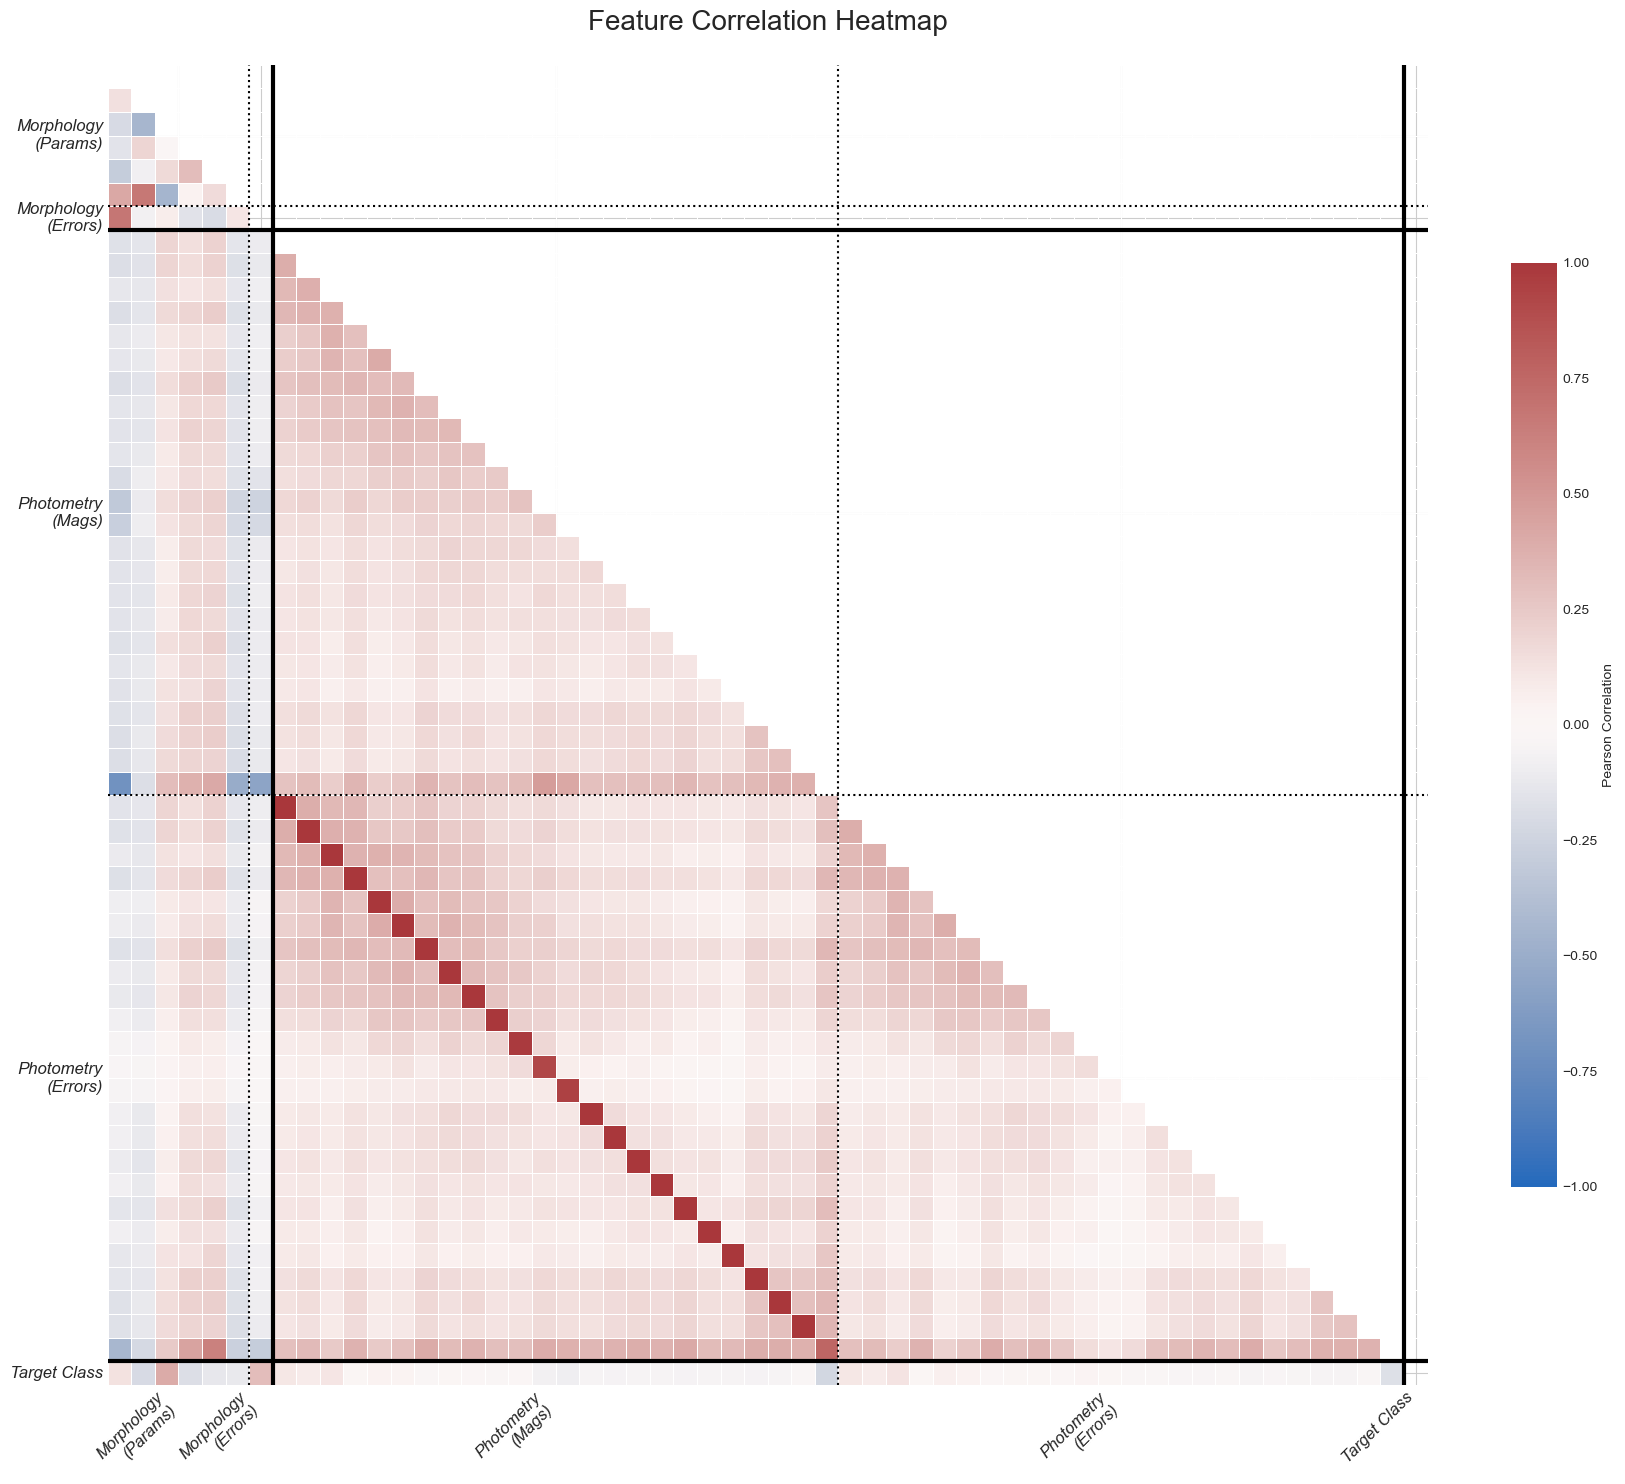

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

# --- Section 1: Setup and Helper Functions (to make the cell standalone) ---

# B. Feature Definitions (from original notebook cell [5])
# This section defines the lists of column names we need.
morphology_features = ['area', 'fwhm', 'stell', 'ell', 'rk', 'rf']
morphology_err = ['s2n']
photometry_magnitudes = [
    'F365W', 'F396W', 'F427W', 'F458W', 'F489W', 'F520W', 'F551W', 'F582W', 'F613W', 'F644W', 
    'F675W', 'F706W', 'F737W', 'F768W', 'F799W', 'F830W', 'F861W', 'F892W', 'F923W', 'F954W',
    'J', 'H', 'KS', 'F814W'
]
photometry_uncertainties = [
    'dF365W', 'dF396W', 'dF427W', 'dF458W', 'dF489W', 'dF520W', 'dF551W', 'dF582W', 'dF613W', 'dF644W', 
    'dF675W', 'dF706W', 'dF737W', 'dF768W', 'dF799W', 'dF830W', 'dF861W', 'dF892W', 'dF923W', 'dF954W',
    'dJ', 'dH', 'dKS', 'dF814W'
]
target_variable = ['acs_mu_class']

# C. Group Definitions (from original notebook cell [5])
# This defines the 'group_3' we want to analyze.
groups = {
    'group_1': morphology_features + morphology_err + target_variable,
    'group_2': photometry_magnitudes + photometry_uncertainties + target_variable,
    'group_3': morphology_features + morphology_err + photometry_magnitudes + photometry_uncertainties + target_variable
}

# D. Helper Functions (get_feature_set and clean_data from original notebook cell [7])
def get_feature_set(df, set_name, groups=groups):
    """Selects columns from a DataFrame based on a predefined feature set name."""
    if set_name not in groups:
        raise ValueError(f"Feature set group '{set_name}' not defined.")
    required_cols = groups[set_name]
    available_cols = [col for col in required_cols if col in df.columns]
    return df[available_cols]

def clean_data(df, feature_group, target_column):
    """Cleans the input DataFrame by selecting features, dropping NaNs, and separating X and y."""
    df_clean = get_feature_set(df, feature_group).dropna().copy()
    if target_column not in df_clean.columns:
        raise KeyError(f"Target column '{target_column}' not found in the cleaned DataFrame.")
    X = df_clean.drop(columns=[target_column])
    y = df_clean[target_column]
    return X, y, df_clean


# --- Section 2: Main Correlation and Plotting Logic ---

# A. Data Loading and Preprocessing (from original notebook cell [4])
try:
    df_original = pd.read_csv('data/match_alhambra_cosmos2020_ACS_class_0.8arcsec.csv')
    # Drop fake detections and map classes to 0 (Galaxy) and 1 (Star)
    df = df_original[df_original['acs_mu_class'] != 3].copy()
    df['acs_mu_class'] = df['acs_mu_class'].map({1: 0, 2: 1})
    print("Successfully loaded and preprocessed the dataset.")
except FileNotFoundError:
    print("Error: Data file not found. Please ensure 'data/match_alhambra_cosmos2020_ACS_class_0.8arcsec.csv' is accessible.")
    # Create a dummy dataframe to allow the rest of the script to run for demonstration
    all_cols_for_dummy = morphology_features + morphology_err + photometry_magnitudes + photometry_uncertainties + target_variable
    df = pd.DataFrame(np.random.rand(100, len(all_cols_for_dummy)), columns=all_cols_for_dummy)
    df['acs_mu_class'] = np.random.randint(0, 2, 100)
    print("Proceeding with a dummy dataframe for demonstration.")


# B. Prepare Data and Feature Order for the Plot
# Define the specific order of features for the plot
g1_mag_cols = morphology_features
g1_err_cols = morphology_err
g2_mag_cols = photometry_magnitudes
g2_err_cols = photometry_uncertainties
target_col = target_variable

# Create the final ordered list of columns
ordered_cols = g1_mag_cols + g1_err_cols + g2_mag_cols + g2_err_cols + target_col

# Use the clean_data function to get the data for group 3 and drop NaNs
_, _, df_group3_clean = clean_data(df, 'group_3', target_variable[0])

# Reorder the cleaned DataFrame columns according to our specified list
df_ordered = df_group3_clean[ordered_cols]
print(f"Prepared data for Group 3 with {df_ordered.shape[1]} features in the specified order.")

# C. Compute Correlation and Create Mask
corr_matrix = df_ordered.corr()
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

# D. Plotting the Heatmap
plt.style.use('seaborn-v0_8-whitegrid')
fig, ax = plt.subplots(figsize=(18, 15))
sns.heatmap(corr_matrix, 
            mask=mask, 
            cmap='vlag',
            vmax=1.0, 
            vmin=-1.0,
            center=0,
            square=True, 
            linewidths=.5, 
            cbar_kws={"shrink": .7, "label": "Pearson Correlation"},
            ax=ax)

# E. Add Separator Lines and Section Labels
section_labels = [
    'Morphology\n(Params)', 
    'Morphology\n(Errors)', 
    'Photometry\n(Mags)', 
    'Photometry\n(Errors)', 
    'Target Class'
]
section_sizes = [len(g1_mag_cols), len(g1_err_cols), len(g2_mag_cols), len(g2_err_cols), len(target_col)]
cumulative_sizes = np.cumsum(section_sizes)
line_positions = cumulative_sizes[:-1]

# Draw horizontal and vertical separator lines
for i, pos in enumerate(line_positions):
    # Dotted line between parameters and errors within a group
    is_internal_divider = (i == 0) or (i == 2)
    linestyle = ':' if is_internal_divider else '-'
    linewidth = 1.5 if is_internal_divider else 3.0
    
    ax.axhline(y=pos, color='black', linestyle=linestyle, linewidth=linewidth)
    ax.axvline(x=pos, color='black', linestyle=linestyle, linewidth=linewidth)

# Calculate positions for section labels (in the middle of each section)
label_positions = [0] + list(cumulative_sizes)
tick_positions = [(label_positions[i] + label_positions[i+1]) / 2 for i in range(len(label_positions)-1)]

# Set custom ticks and labels
ax.set_xticks(tick_positions)
ax.set_xticklabels(section_labels, rotation=45, ha='right', fontsize=12, style='italic')
ax.set_yticks(tick_positions)
ax.set_yticklabels(section_labels, rotation=0, va='center', fontsize=12, style='italic')

# F. Final Touches
ax.tick_params(axis='both', which='major', length=0) # Hide tick marks for a cleaner look
ax.set_title('Feature Correlation Heatmap', fontsize=20, pad=25)
plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()

In [9]:
# Check for boolean flags and count flagged objects
flag_columns = ['model_flag', 'flag_hsc', 'flag_supcam', 'flag_udeep', 'flag_uvista', 
                'irms_OPT_Flag', 'irms_NIR_Flag', 'photoflag']

print("\n--- Flag Statistics ---")
print("Checking flag types and counts:")
for flag in flag_columns:
    if flag in df.columns:
        # Check if column is boolean or contains only 0/1
        unique_vals = df[flag].unique()
        is_binary = set(unique_vals).issubset({0, 1, True, False})
        
        flagged_count = df[flag].sum() if is_binary else df[df[flag] > 0].shape[0]
        flag_perc = (flagged_count / len(df)) * 100
        
        print(f"\n{flag}:")
        print(f"Unique values: {unique_vals}")
        print(f"Number of flagged objects: {flagged_count:,} ({flag_perc:.2f}%)")
print("-" * 35)



--- Flag Statistics ---
Checking flag types and counts:

model_flag:
Unique values: [0]
Number of flagged objects: 0 (0.00%)

flag_hsc:
Unique values: [0 1]
Number of flagged objects: 84 (0.31%)

flag_supcam:
Unique values: [0 1]
Number of flagged objects: 1,273 (4.65%)

flag_udeep:
Unique values: [1 0]
Number of flagged objects: 16,159 (59.00%)

flag_uvista:
Unique values: [0]
Number of flagged objects: 0 (0.00%)

irms_OPT_Flag:
Unique values: [ 0  2  1  4  3 11 10  9  5  7  8  6]
Number of flagged objects: 420 (1.53%)

irms_NIR_Flag:
Unique values: [0 1 2 3]
Number of flagged objects: 2,314 (8.45%)

photoflag:
Unique values: [3 2 0 1]
Number of flagged objects: 7,906 (28.87%)
-----------------------------------


In [19]:
# Calculate matches and mismatches
stars_match = df[(df['Stellar_Flag'] > 0.7) & (df['acs_mu_class'] == 2)].shape[0]
galaxies_match = df[(df['Stellar_Flag'] <= 0.7) & (df['acs_mu_class'] == 1)].shape[0]

# Calculate percentages
stars_match_perc = (stars_match / total_objects) * 100
galaxies_match_perc = (galaxies_match / total_objects) * 100

print("\n--- Classification Agreement Statistics ---")
print(f"Stars correctly classified: {stars_match} ({stars_match_perc:.1f}%)")
print(f"Galaxies correctly classified: {galaxies_match} ({galaxies_match_perc:.1f}%)")

# Calculate discrepancies
stars_missed = acs_stars - stars_match  # ACS stars missed by ALHAMBRA
false_stars = alh_stars_est - stars_match  # False stars by ALHAMBRA
galaxies_missed = acs_galaxies - galaxies_match  # ACS galaxies missed by ALHAMBRA
false_galaxies = alh_galaxies_est - galaxies_match  # False galaxies by ALHAMBRA

print("\n--- Classification Discrepancies ---")
print(f"Stars missed by ALHAMBRA: {stars_missed} ({(stars_missed/acs_stars*100):.1f}% of ACS stars)")
print(f"False stars by ALHAMBRA: {false_stars} ({(false_stars/alh_stars_est*100):.1f}% of ALHAMBRA stars)")
print(f"Galaxies missed by ALHAMBRA: {galaxies_missed} ({(galaxies_missed/acs_galaxies*100):.1f}% of ACS galaxies)")
print(f"False galaxies by ALHAMBRA: {false_galaxies} ({(false_galaxies/alh_galaxies_est*100):.1f}% of ALHAMBRA galaxies)")
print("-" * 35)
# Calculate total correct classifications
total_correct = stars_match + galaxies_match
total_correct_perc = (total_correct / total_objects) * 100

print("\n--- Overall Classification Accuracy ---")
print(f"Total correctly classified objects: {total_correct:,} ({total_correct_perc:.1f}%)")
print("-" * 35)




--- Classification Agreement Statistics ---
Stars correctly classified: 854 (3.1%)
Galaxies correctly classified: 25350 (92.6%)

--- Classification Discrepancies ---
Stars missed by ALHAMBRA: 1072 (55.7% of ACS stars)
False stars by ALHAMBRA: 112 (11.6% of ALHAMBRA stars)
Galaxies missed by ALHAMBRA: 112 (0.4% of ACS galaxies)
False galaxies by ALHAMBRA: 1073 (4.1% of ALHAMBRA galaxies)
-----------------------------------

--- Overall Classification Accuracy ---
Total correctly classified objects: 26,204 (95.7%)
-----------------------------------


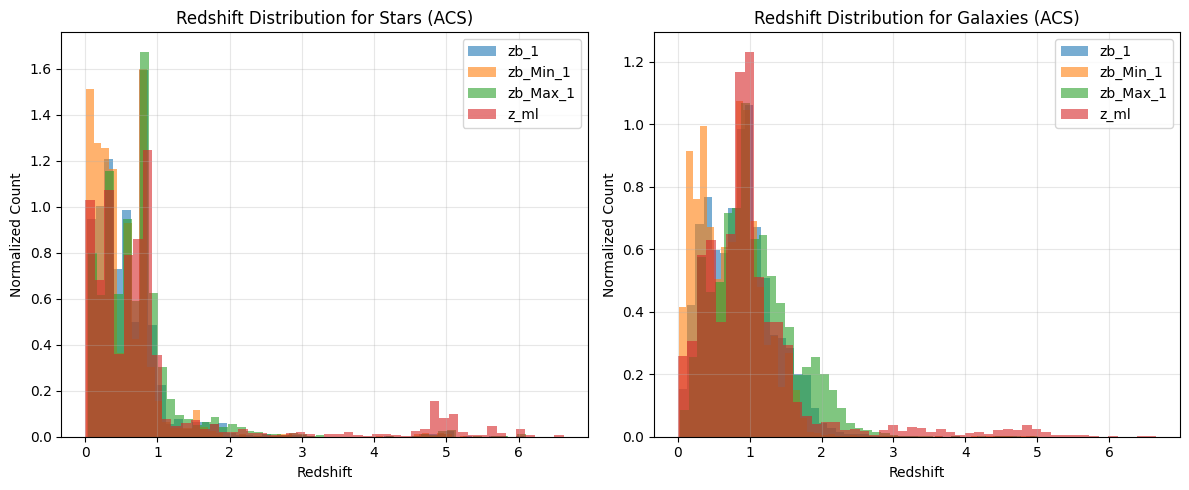


--- Redshift Statistics ---
Stars (ACS):
Mean zb_1: 0.627
Mean z_ml: 0.963

Galaxies (ACS):
Mean zb_1: 0.884
Mean z_ml: 1.053
-----------------------------------


In [4]:
# Create figure for stars and galaxies histograms
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Stars (acs_mu_class == 2)
stars_mask = df['acs_mu_class'] == 2
ax1.hist(df[stars_mask]['zb_1'], bins=50, alpha=0.6, label='zb_1', density=True)
ax1.hist(df[stars_mask]['zb_Min_1'], bins=50, alpha=0.6, label='zb_Min_1', density=True)
ax1.hist(df[stars_mask]['zb_Max_1'], bins=50, alpha=0.6, label='zb_Max_1', density=True)
ax1.hist(df[stars_mask]['z_ml'], bins=50, alpha=0.6, label='z_ml', density=True)

ax1.set_title('Redshift Distribution for Stars (ACS)')
ax1.set_xlabel('Redshift')
ax1.set_ylabel('Normalized Count')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Galaxies (acs_mu_class == 1) 
galaxies_mask = df['acs_mu_class'] == 1
ax2.hist(df[galaxies_mask]['zb_1'], bins=50, alpha=0.6, label='zb_1', density=True)
ax2.hist(df[galaxies_mask]['zb_Min_1'], bins=50, alpha=0.6, label='zb_Min_1', density=True)
ax2.hist(df[galaxies_mask]['zb_Max_1'], bins=50, alpha=0.6, label='zb_Max_1', density=True)
ax2.hist(df[galaxies_mask]['z_ml'], bins=50, alpha=0.6, label='z_ml', density=True)

ax2.set_title('Redshift Distribution for Galaxies (ACS)')
ax2.set_xlabel('Redshift') 
ax2.set_ylabel('Normalized Count')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print summary statistics
print("\n--- Redshift Statistics ---")
print("Stars (ACS):")
print(f"Mean zb_1: {df[stars_mask]['zb_1'].mean():.3f}")
print(f"Mean z_ml: {df[stars_mask]['z_ml'].mean():.3f}")
print("\nGalaxies (ACS):")
print(f"Mean zb_1: {df[galaxies_mask]['zb_1'].mean():.3f}")
print(f"Mean z_ml: {df[galaxies_mask]['z_ml'].mean():.3f}")
print("-" * 35)


In [5]:
# Calculate matches between ALHAMBRA and ACS classifications
stars_match = df[(df['Stellar_Flag'] > 0.8) & (df['acs_mu_class'] == 2)].shape[0]
galaxies_match = df[(df['Stellar_Flag'] < 0.2) & (df['acs_mu_class'] == 1)].shape[0]

# Calculate percentages
stars_match_perc = (stars_match / total_objects) * 100
galaxies_match_perc = (galaxies_match / total_objects) * 100

print("\n--- Classification Agreement Statistics ---")
print(f"Stars (Stellar_Flag > 0.8) matching ACS: {stars_match} ({stars_match_perc:.1f}%)")
print(f"Galaxies (Stellar_Flag < 0.2) matching ACS: {galaxies_match} ({galaxies_match_perc:.1f}%)")
print(f"Total matching classifications: {stars_match + galaxies_match} ({stars_match_perc + galaxies_match_perc:.1f}%)")
print("-" * 35)


NameError: name 'total_objects' is not defined

# Theory plots

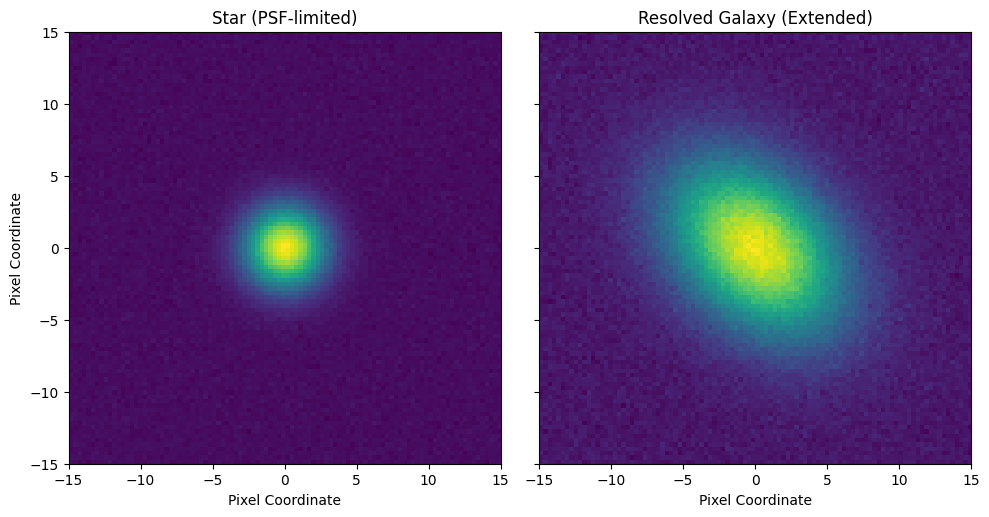

In [6]:
import numpy as np
import matplotlib.pyplot as plt

def gaussian_2d(xy_mesh, amp, xc, yc, sigma_x, sigma_y, theta):
    """Creates a 2D Gaussian profile."""
    (x, y) = xy_mesh
    a = (np.cos(theta)**2)/(2*sigma_x**2) + (np.sin(theta)**2)/(2*sigma_y**2)
    b = -(np.sin(2*theta))/(4*sigma_x**2) + (np.sin(2*theta))/(4*sigma_y**2)
    c = (np.sin(theta)**2)/(2*sigma_x**2) + (np.cos(theta)**2)/(2*sigma_y**2)
    g = amp * np.exp( - (a*((x-xc)**2) + 2*b*(x-xc)*(y-yc) + c*((y-yc)**2)))
    return g

# Create grid
x = np.linspace(-15, 15, 100)
y = np.linspace(-15, 15, 100)
xx, yy = np.meshgrid(x, y)

# --- Star (PSF) ---
# Simulate a PSF (relatively sharp Gaussian)
sigma_psf = 2.0
star_psf = gaussian_2d((xx, yy), 1, 0, 0, sigma_psf, sigma_psf, 0)
# Add a little noise
star_psf += np.random.normal(0, 0.01, size=star_psf.shape)

# --- Galaxy ---
# Simulate a slightly resolved galaxy (broader profile, maybe elliptical)
sigma_gal_x = 5.0
sigma_gal_y = 3.5
theta_gal = np.pi / 4 # 45 degree angle
galaxy_profile = gaussian_2d((xx, yy), 0.5, 0, 0, sigma_gal_x, sigma_gal_y, theta_gal)
# Add a little noise
galaxy_profile += np.random.normal(0, 0.01, size=galaxy_profile.shape)

# --- Plotting ---
fig, axs = plt.subplots(1, 2, figsize=(10, 5), sharey=True)

im_star = axs[0].imshow(star_psf, origin='lower', cmap='viridis', 
                        extent=[x.min(), x.max(), y.min(), y.max()])
axs[0].set_title('Star (PSF-limited)')
axs[0].set_xlabel('Pixel Coordinate')
axs[0].set_ylabel('Pixel Coordinate')
#fig.colorbar(im_star, ax=axs[0], fraction=0.046, pad=0.04)

im_gal = axs[1].imshow(galaxy_profile, origin='lower', cmap='viridis', 
                      extent=[x.min(), x.max(), y.min(), y.max()])
axs[1].set_title('Resolved Galaxy (Extended)')
axs[1].set_xlabel('Pixel Coordinate')
#fig.colorbar(im_gal, ax=axs[1], fraction=0.046, pad=0.04)

plt.tight_layout()
plt.savefig('morphology_comparison.png', dpi=300)
plt.show()

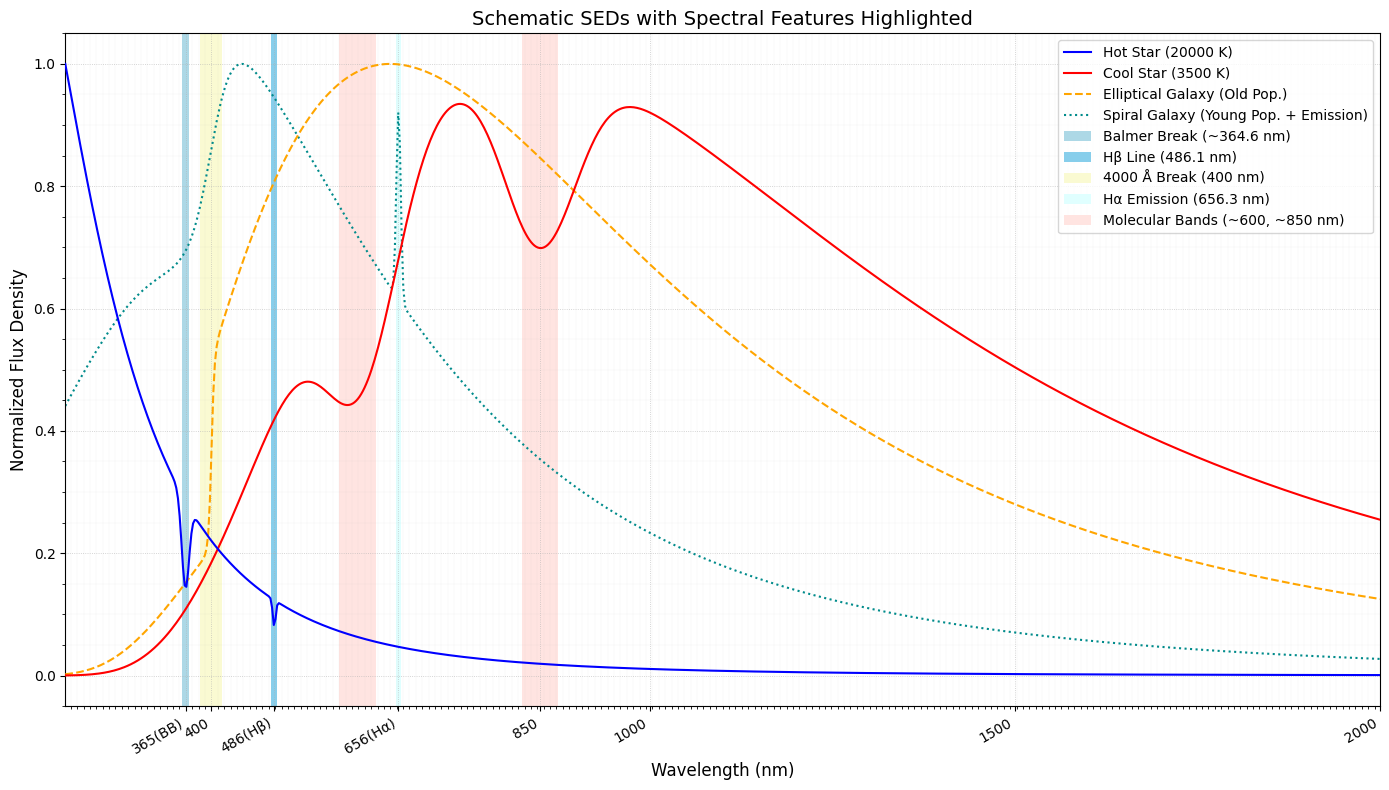

In [44]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches # Import patches for legend

# Constants for Planck's Law
h = 6.626e-34  # Planck's constant (J*s)
c = 3.0e8      # Speed of light (m/s)
k_b = 1.38e-23 # Boltzmann constant (J/K)

def planck(wav, T):
    """Calculates Planck's law B_lambda(T). wav in nm. Returns normalized intensity."""
    wav_m = wav * 1e-9  # Convert nm to m
    a = 2.0 * h * c**2
    b = h * c / (wav_m * k_b * T)
    # Clip b to avoid overflow in np.exp
    b_clipped = np.clip(b, -700, 700)
    # Add small epsilon to avoid division by zero if exp(b) is exactly 1
    denominator = (wav_m**5) * (np.exp(b_clipped) - 1.0 + 1e-100)
    intensity = np.zeros_like(wav_m)
    # Only calculate where denominator is reasonably large
    valid = denominator > 1e-100
    intensity[valid] = a / denominator[valid]
    # Find max finite intensity for normalization
    finite_intensity = intensity[np.isfinite(intensity)]
    if finite_intensity.size > 0:
        max_intensity = np.max(finite_intensity)
        if max_intensity > 0:
             # Normalize before returning
            return intensity / max_intensity
        else:
            return np.zeros_like(intensity) # Handle case where max is zero
    else:
        return np.zeros_like(intensity) # Handle case where all are non-finite


def gaussian(x, mu, sig, amp=1.0):
    """Gaussian function for lines/filters."""
    return amp * np.exp(-np.power(x - mu, 2.) / (2 * np.power(sig, 2.)))

# Wavelength range (logarithmic for broader view, but plot linearly)
wavelength = np.linspace(200, 2500, 1000)  # Linear spacing for smoother features

# --- Stellar SEDs ---
temp_hot_star = 20000  # K (~B type star)
temp_cool_star = 3500  # K (~M type star)
sed_hot_star_raw = planck(wavelength, temp_hot_star)
sed_cool_star_raw = planck(wavelength, temp_cool_star)

# Define Absorption/Emission line locations
balmer_discontinuity_loc = 364.6  # More precise nm
h_beta_loc = 486.1  # nm
h_alpha_loc = 656.3  # nm

# Add symbolic absorption lines to hot star
sed_hot_star = sed_hot_star_raw * (1 - gaussian(wavelength, balmer_discontinuity_loc, 5, 0.5)  # Smoother Balmer discontinuity
                                   - gaussian(wavelength, h_beta_loc, 2, 0.35))    # H-beta
sed_hot_star = np.clip(sed_hot_star, 0, None) # Clip at 0 for linear scale

# Add features to cool star
mol_band1_loc = 600  # nm
mol_band2_loc = 850  # nm
mol_band1_width = 50
mol_band2_width = 50
mol_band1_depth = 0.4
mol_band2_depth = 0.3
sed_cool_star = sed_cool_star_raw * (1 - gaussian(wavelength, mol_band1_loc, mol_band1_width, mol_band1_depth)  # Broad molecular band
                                     - gaussian(wavelength, mol_band2_loc, mol_band2_width, mol_band2_depth))  # Another band area
sed_cool_star = np.clip(sed_cool_star, 0, None) # Clip at 0 for linear scale


# --- Galaxy SEDs ---
# Elliptical (Old stars, strong 4000 Å break)
temp_elliptical_eff = 4500
sed_elliptical_raw = planck(wavelength, temp_elliptical_eff) # Already normalized by planck function
break_loc = 400.0  # nm (4000 Å)
break_strength_E = 0.6 # Fractional drop (flux after break is 1-0.6 = 0.4 of flux before)
taper_scale_E = 2 # Sharper taper scale for sharper visual break
sed_elliptical = sed_elliptical_raw.copy()
# Sigmoid for smooth break: flux_after = flux_before * [ (1-strength) + strength / (1 + exp(-(wav - loc)/delta)) ]
# Here, we multiply by the factor directly
break_effect = (1 - break_strength_E) + break_strength_E / (1 + np.exp(-(wavelength - break_loc) / taper_scale_E))
# Apply the break by multiplying (flux REDUCES blueward of the break)
sed_elliptical_broken = sed_elliptical_raw * break_effect # Apply break
# Renormalize AFTER applying the break so the peak is still ~1
max_elliptical = np.max(sed_elliptical_broken[np.isfinite(sed_elliptical_broken)])
sed_elliptical_plot = sed_elliptical_broken / max_elliptical if max_elliptical > 0 else sed_elliptical_broken
sed_elliptical_plot = np.clip(sed_elliptical_plot, 0, None) # Clip at 0


# Spiral (Younger stars, weaker break, emission line)
temp_spiral_mix1 = 7000
temp_spiral_mix2 = 15000
# Combine Planck functions (already normalized individually, combination needs renormalization)
sed_spiral_cont_raw = 0.6 * planck(wavelength, temp_spiral_mix1) + 0.4 * planck(wavelength, temp_spiral_mix2)
# Renormalize the combined continuum
max_cont = np.max(sed_spiral_cont_raw[np.isfinite(sed_spiral_cont_raw)])
sed_spiral_cont = sed_spiral_cont_raw / max_cont if max_cont > 0 else sed_spiral_cont_raw

break_strength_S = 0.4 # Weaker break
taper_scale_S = 15 # Slightly broader taper
sed_spiral = sed_spiral_cont.copy()
break_effect_S = (1 - break_strength_S) + break_strength_S / (1 + np.exp(-(wavelength - break_loc) / taper_scale_S))
sed_spiral *= break_effect_S # Apply break

# Add H-alpha emission line to spiral
h_alpha_width = 3 # Make emission line slightly narrower
h_alpha_amp_relative = 0.5 # Amplitude relative to continuum *at that point*
cont_level_halpha = np.interp(h_alpha_loc, wavelength, sed_spiral) # Get continuum level near H-alpha
if cont_level_halpha > 0:
    sed_spiral += gaussian(wavelength, h_alpha_loc, h_alpha_width, h_alpha_amp_relative * cont_level_halpha)

# Renormalize the FINAL spiral SED (including break and emission)
max_spiral = np.max(sed_spiral[np.isfinite(sed_spiral)])
sed_spiral_plot = sed_spiral / max_spiral if max_spiral > 0 else sed_spiral
sed_spiral_plot = np.clip(sed_spiral_plot, 0, None) # Clip at 0

# --- Plotting ---
fig, ax = plt.subplots(figsize=(14, 8)) # Adjusted figure size slightly

# Set y-limits suitable for NORMALIZED LINEAR scale
ymin_plot = -0.05 # Allow seeing the baseline
ymax_plot = 1.05   # Go a bit above 1 to accommodate H-alpha peak
ax.set_ylim(ymin_plot, ymax_plot)
ax.set_xlim(200, 2000) # Keep original x-limits

# --- Define Feature Bands ---
# Use distinct colors and alpha for transparency
# Define colors using a palette or specify directly
color_balmer_break = 'lightblue'      # *** Color for Balmer Break ***
color_h_beta = 'skyblue'            # *** DIFFERENT Color for H-beta ***
color_4000a = 'lightgoldenrodyellow' # Changed for better visibility than wheat
color_halpha = 'lightcyan'
color_mol = 'mistyrose'
band_alpha = 1 # Transparency level for bands
band_zorder = 0 # Draw bands behind the SED lines

# Balmer Series Features (Discontinuity, Hδ, Hγ, Hβ)
# *** Use specific colors for break and H-beta ***
ax.axvspan(360, 370, color=color_balmer_break, alpha=band_alpha, zorder=band_zorder, lw=0) # Balmer Break/Limit
ax.axvspan(h_beta_loc - 4, h_beta_loc + 4, color=color_h_beta, alpha=band_alpha, zorder=band_zorder, lw=0) # H-beta

# 4000 Angstrom Break
ax.axvspan(break_loc - 15, break_loc + 15, color=color_4000a, alpha=band_alpha, zorder=band_zorder, lw=0) # Wider band for the break region

# H-alpha Emission Line
ax.axvspan(h_alpha_loc - 4, h_alpha_loc + 4, color=color_halpha, alpha=band_alpha, zorder=band_zorder, lw=0) # H-alpha

# Molecular Bands (Cool Star)
ax.axvspan(mol_band1_loc - mol_band1_width/2, mol_band1_loc + mol_band1_width/2, color=color_mol, alpha=band_alpha, zorder=band_zorder, lw=0) # Mol Band 1
ax.axvspan(mol_band2_loc - mol_band2_width/2, mol_band2_loc + mol_band2_width/2, color=color_mol, alpha=band_alpha, zorder=band_zorder, lw=0) # Mol Band 2


# Plot SEDs (draw AFTER bands using higher zorder)
line_hot, = ax.plot(wavelength, sed_hot_star, label=f'Hot Star ({temp_hot_star} K)', color='blue', zorder=5, lw=1.5)
line_cool, = ax.plot(wavelength, sed_cool_star, label=f'Cool Star ({temp_cool_star} K)', color='red', zorder=4, lw=1.5)
line_ell, = ax.plot(wavelength, sed_elliptical_plot, label='Elliptical Galaxy (Old Pop.)', color='orange', linestyle='--', zorder=3, lw=1.5)
line_spi, = ax.plot(wavelength, sed_spiral_plot, label='Spiral Galaxy (Young Pop. + Emission)', color='darkcyan', linestyle=':', zorder=2, lw=1.5) # Changed color slightly


# --- Create Legend ---
# Get handles and labels from the plotted lines
handles, labels = ax.get_legend_handles_labels()

# Create patch handles for the bands to add to the legend
# *** Create SEPARATE patches for Balmer Break and H-beta ***
patch_balmer_break = mpatches.Patch(color=color_balmer_break, alpha=band_alpha, lw=0, label=f'Balmer Break (~{balmer_discontinuity_loc:.1f} nm)')
patch_h_beta = mpatches.Patch(color=color_h_beta, alpha=band_alpha, lw=0, label=f'Hβ Line ({h_beta_loc:.1f} nm)')
patch_4000a = mpatches.Patch(color=color_4000a, alpha=band_alpha, lw=0, label=f'4000 Å Break ({break_loc:.0f} nm)')
patch_halpha = mpatches.Patch(color=color_halpha, alpha=band_alpha, lw=0, label=f'Hα Emission ({h_alpha_loc:.1f} nm)')
patch_mol = mpatches.Patch(color=color_mol, alpha=band_alpha, lw=0, label=f'Molecular Bands (~{mol_band1_loc:.0f}, ~{mol_band2_loc:.0f} nm)')

# Append band patches to the handles list
# *** Append the two separate Balmer-related patches ***
handles.extend([patch_balmer_break, patch_h_beta, patch_4000a, patch_halpha, patch_mol])

# Add legend to the plot
ax.legend(handles=handles, loc='upper right', fontsize=10) # Increased font size slightly


# --- Final Plot Adjustments ---
ax.set_xlabel('Wavelength (nm)', fontsize=12)
ax.set_ylabel('Normalized Flux Density', fontsize=12)
ax.set_title('Schematic SEDs with Spectral Features Highlighted', fontsize=14)

# Customize ticks and grid
# Added Balmer break location to ticks for clarity
ax.set_xticks([365, 400,  486, 656, 850, 1000, 1500, 2000])
ax.set_xticklabels(['365(BB)', '400', '486(Hβ)', '656(Hα)', '850', '1000', '1500', '2000'], rotation=30, ha='right')
ax.minorticks_on()
ax.grid(True, which='major', linestyle=':', linewidth=0.6, alpha=0.7)
ax.grid(True, which='minor', linestyle=':', linewidth=0.3, alpha=0.4)

# Adjust layout to prevent labels overlapping
plt.tight_layout()
plt.savefig('sed_comparison_bands_legend_diff_balmer.png', dpi=300) # Updated filename
plt.show()

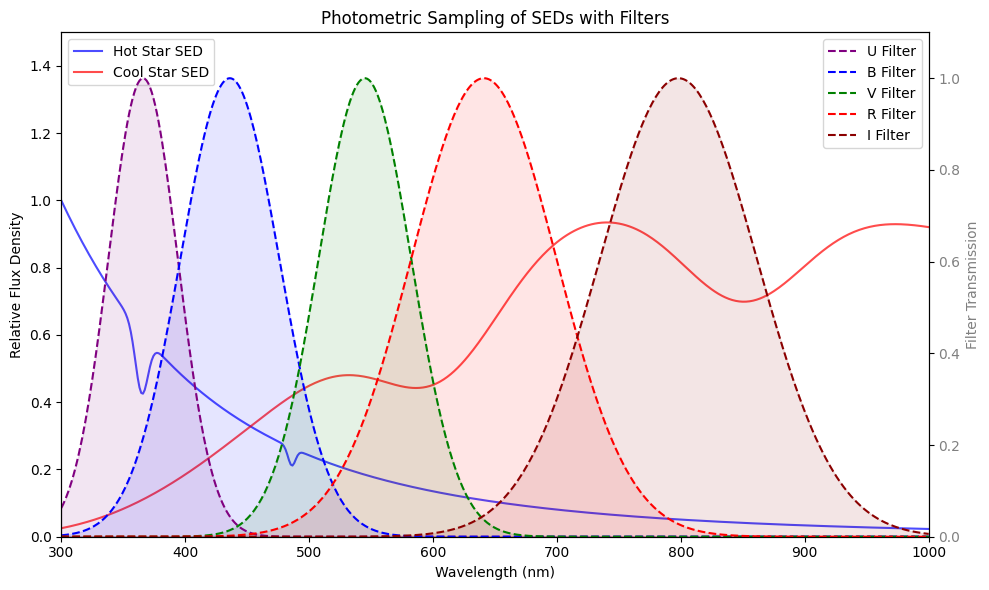

In [15]:
import numpy as np
import matplotlib.pyplot as plt

# Import functions from plot_seds.py (or copy them here)
# Constants for Planck's Law
h = 6.626e-34  # Planck's constant (J*s)
c = 3.0e8      # Speed of light (m/s)
k_b = 1.38e-23 # Boltzmann constant (J/K)

def planck(wav, T):
    """Calculates Planck's law B_lambda(T). wav in nm."""
    wav_m = wav * 1e-9 # Convert nm to m
    a = 2.0*h*c**2
    b = h*c/(wav_m*k_b*T)
    intensity = a/ ( (wav_m**5) * (np.exp(b) - 1.0) )
    return intensity / np.max(intensity) if np.max(intensity) > 0 else intensity

def gaussian(x, mu, sig, amp=1.0):
    """Gaussian function for lines/filters."""
    return amp * np.exp(-np.power(x - mu, 2.) / (2 * np.power(sig, 2.)))

# Wavelength range
wavelength = np.linspace(300, 1000, 500) # Focus on UBVRI range

# --- Stellar SEDs (Simplified for clarity) ---
sed_hot_star = planck(wavelength, 20000)
sed_cool_star = planck(wavelength, 3500)
# Apply basic symbolic lines/breaks
sed_hot_star *= (1 - gaussian(wavelength, 365, 5, 0.3) - gaussian(wavelength, 486, 3, 0.2))
sed_cool_star *= (1 - gaussian(wavelength, 600, 50, 0.4) - gaussian(wavelength, 850, 50, 0.3))


# --- Filter Profiles (Approximate Gaussians) ---
# Central wavelengths and FWHM from Table 10.2 (Chromey) / typical values
filters = {
    'U': {'center': 366, 'fwhm': 66},
    'B': {'center': 436, 'fwhm': 94},
    'V': {'center': 545, 'fwhm': 88},
    'R': {'center': 641, 'fwhm': 138}, # Rc
    'I': {'center': 798, 'fwhm': 149}  # Ic
}
filter_transmissions = {}
for band, params in filters.items():
    sigma = params['fwhm'] / (2.0 * np.sqrt(2.0 * np.log(2.0))) # Convert FWHM to sigma
    filter_transmissions[band] = gaussian(wavelength, params['center'], sigma, amp=1.0)

# --- Plotting ---
fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot SEDs on primary y-axis
ax1.plot(wavelength, sed_hot_star, label='Hot Star SED', color='blue', alpha=0.7)
ax1.plot(wavelength, sed_cool_star, label='Cool Star SED', color='red', alpha=0.7)
ax1.set_xlabel('Wavelength (nm)')
ax1.set_ylabel('Relative Flux Density', color='black')
ax1.tick_params(axis='y', labelcolor='black')
ax1.set_ylim(0, 1.5) # Adjust as needed
ax1.legend(loc='upper left')

# Plot filters on secondary y-axis
ax2 = ax1.twinx()
colors = ['purple', 'blue', 'green', 'red', 'darkred']
for i, (band, transmission) in enumerate(filter_transmissions.items()):
    ax2.plot(wavelength, transmission, label=f'{band} Filter', color=colors[i], linestyle='--')
    ax2.fill_between(wavelength, 0, transmission, color=colors[i], alpha=0.1)
ax2.set_ylabel('Filter Transmission', color='gray')
ax2.tick_params(axis='y', labelcolor='gray')
ax2.set_ylim(0, 1.1)
ax2.legend(loc='upper right')

plt.title('Photometric Sampling of SEDs with Filters')
plt.xlim(300, 1000)
plt.grid(True, which='both', linestyle=':', linewidth=0.5, axis='x')
fig.tight_layout()
plt.savefig('photometry_sampling.png', dpi=300)
plt.show()

## DEA ALHAMBRA CAT

Corresponds to [Molino et al.](http://adsabs.harvard.edu/abs/2014MNRAS.441.2891M)

As you can see,
if you look at the distribution in (ra, dec) it contains data in all 7 
ALHAMBRA fields. The columns in this catalog should correspond to those 
described in the Molino et al. paper (if there are any added or missing 
columns, please ask me). I'm sending you the complete catalog to have it, 
but you'll probably want to work most of the time with the labeled sample 
from the csv.


In [13]:
alhambra_df[['F365W', 'dF365W', 'F396W', 'dF396W', 'F427W', 'dF427W', 'F458W', 'dF458W', 'F489W', 'dF489W', 'F520W', 'dF520W', 'F551W', 'dF551W', 'F582W', 'dF582W', 'F613W', 'dF613W', 'F644W', 'dF644W', 'F675W', 'dF675W', 'F706W', 'dF706W', 'F737W', 'dF737W', 'F768W', 'dF768W', 'F799W', 'dF799W', 'F830W', 'dF830W', 'F861W', 'dF861W', 'F892W', 'dF892W', 'F923W', 'dF923W', 'F954W', 'dF954W']].describe()

F365W         dF365W          F396W         dF396W  \
count  378614.000000  378614.000000  378614.000000  378614.000000   
mean       47.406615       8.119383      39.639435       5.509518   
std        34.155433      11.398596      29.745295      10.167135   
min        15.494000       0.001000      15.671000       0.000000   
25%        24.601000       0.369000      24.352000       0.200000   
50%        25.486000       0.750000      25.226000       0.433000   
75%        99.000000      24.780000      26.347000       1.070000   
max        99.000000      27.750000      99.000000      27.630000   

               F427W         dF427W          F458W         dF458W  \
count  378614.000000  378614.000000  378614.000000  378614.000000   
mean       36.798942       4.503968      35.075094       3.952512   
std        27.317830       9.367659      25.679908       8.802775   
min        14.833000       0.001000      14.836000       0.000000   
25%        24.359000       0.174000      24.308000       0.199000   
50%        25.239000       0.369000      25.190000       0.386000   
75%        26.239000       0.862000      26.117000       0.808000   
max        99.000000      27.500000      99.000000      31.038000   

               F489W         dF489W  ...          F830W         dF830W  \
count  378614.000000  378614.000000  ...  378614.000000  378614.000000   
mean       31.119136       2.570266  ...      25.834045       1.020261   
std        20.940690       7.308639  ...      12.849034       4.251195   
min        14.134000       0.000000  ...      13.309000       0.000000   
25%        24.119000       0.131000  ...      22.909250       0.113000   
50%        25.008000       0.261000  ...      23.964000       0.230000   
75%        25.870000       0.529000  ...      24.759000       0.400000   
max        99.000000      27.840000  ...      99.000000      26.830000   

               F861W         dF861W          F892W         dF892W  \
count  378614.000000  378614.000000  378614.000000  378614.000000   
mean       25.092600       0.775324      28.408259       1.989777   
std        10.976813       3.593778      19.089850       6.113862   
min        13.266000       0.000000      13.171000       0.001000   
25%        22.768000       0.096000      22.682000       0.148000   
50%        23.827000       0.192000      23.688000       0.301000   
75%        24.626000       0.346000      24.474000       0.539000   
max        99.000000      27.329000      99.000000      26.858000   

               F923W         dF923W          F954W         dF954W  
count  378614.000000  378614.000000  378614.000000  378614.000000  
mean       31.663810       3.064912      33.758483       3.750243  
std        23.950729       7.424547      26.854626       8.011721  
min        13.185000       0.001000      13.312000       0.002000  
25%        22.664000       0.205000      22.330000       0.251000  
50%        23.656000       0.409000      23.181000       0.458000  
75%        24.493000       0.751000      24.019000       0.855000  
max        99.000000      26.100000      99.000000      25.200000  

[8 rows x 40 columns]

ALHAMBRA Catalog Shape: (378614, 109)

ALHAMBRA Catalog Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 378614 entries, 0 to 378613
Columns: 109 entries, #ID to irms_NIR_Flag
dtypes: float64(101), int64(8)
memory usage: 314.9 MB

Numerical columns:
['#ID', 'RA', 'Dec', 'x', 'y', 'area', 'fwhm', 'stell', 'ell', 'a', 'b', 'theta', 'rk', 'rf', 's2n', 'photoflag', 'F365W', 'dF365W', 'F396W', 'dF396W', 'F427W', 'dF427W', 'F458W', 'dF458W', 'F489W', 'dF489W', 'F520W', 'dF520W', 'F551W', 'dF551W', 'F582W', 'dF582W', 'F613W', 'dF613W', 'F644W', 'dF644W', 'F675W', 'dF675W', 'F706W', 'dF706W', 'F737W', 'dF737W', 'F768W', 'dF768W', 'F799W', 'dF799W', 'F830W', 'dF830W', 'F861W', 'dF861W', 'F892W', 'dF892W', 'F923W', 'dF923W', 'F954W', 'dF954W', 'J', 'dJ', 'H', 'dH', 'KS', 'dKS', 'F814W', 'dF814W', 'F814W_3arcs', 'dF814W_3arcs', 'F814W_3arcs_corr', 'nfobs', 'xray', 'PercW', 'Satur_Flag', 'Stellar_Flag', 'zb_1', 'zb_Min_1', 'zb_Max_1', 'Tb_1', 'Odds_1', 'z_ml', 't_ml', 'Chi2', 'Stell_Mass_1'

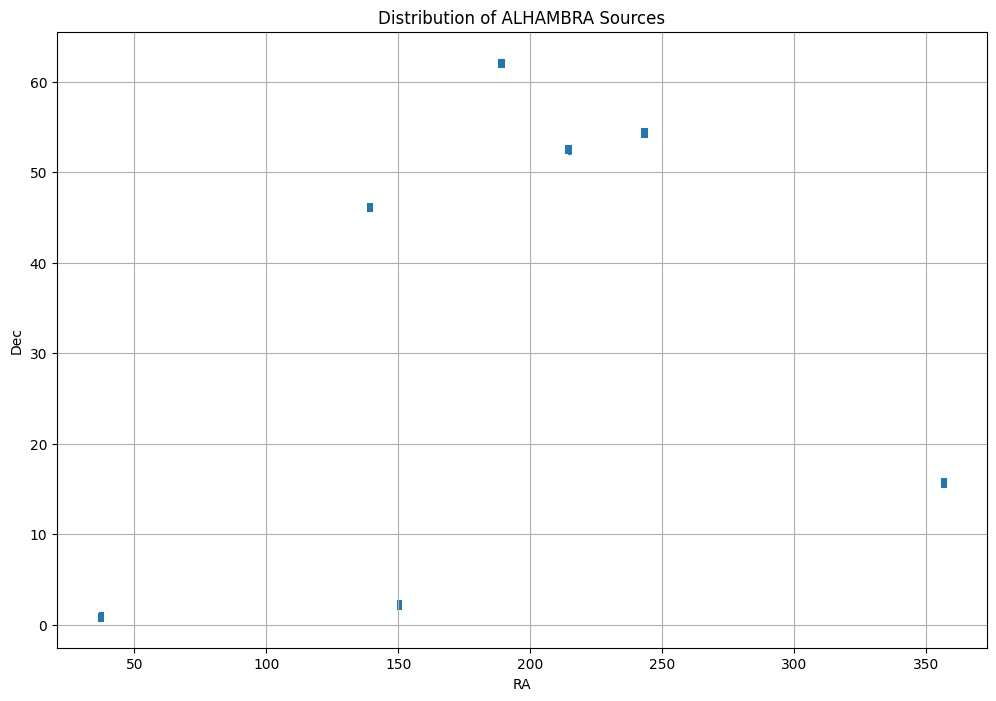

In [15]:
# Get basic information about the ALHAMBRA catalog
print("ALHAMBRA Catalog Shape:", alhambra_df.shape)
print("\nALHAMBRA Catalog Info:")
alhambra_df.info()

# Separate numerical and categorical columns
numerical_columns = alhambra_df.select_dtypes(include=['int64', 'float64']).columns
categorical_columns = alhambra_df.select_dtypes(include=['object', 'category', 'bool']).columns

print("\nNumerical columns:")
print(numerical_columns.tolist())

print("\nCategorical columns:")
print(categorical_columns.tolist())



# Basic statistics of the catalog
print("\nNumerical Columns Summary:")
print(alhambra_df.describe())

# Check distribution of RA and Dec to verify the 7 ALHAMBRA fields
print("\nRA and Dec distribution:")
print("\nRA statistics:")
print(alhambra_df['RA'].describe())
print("\nDec statistics:")
print(alhambra_df['Dec'].describe())

# Check for missing values
missing_values = alhambra_df.isnull().sum()
print(f"\nMissing values in ALHAMBRA catalog:{missing_values}")

# Display first few rows of the catalog
print("\nFirst few rows of the ALHAMBRA catalog:")
print(alhambra_df.head())


# Create a scatter plot of RA vs Dec to visualize the fields
fig, ax = plt.subplots(figsize=(12, 8))
ax.scatter(alhambra_df['RA'], alhambra_df['Dec'], alpha=0.1, s=1)
ax.set_xlabel('RA')
ax.set_ylabel('Dec')
ax.set_title('Distribution of ALHAMBRA Sources')
ax.grid(True)
plt.show()

In [3]:
ra_unique_values = alhambra_df['RA'].nunique()
dec_unique_values = alhambra_df['Dec'].nunique()

print(f"Number of unique values in RA: {ra_unique_values}")
print(f"Number of unique values in Dec: {dec_unique_values}")


Number of unique values in RA: 78585
Number of unique values in Dec: 33569


Plotting ellipses: 100%|██████████| 33611/33611 [01:41<00:00, 330.99it/s]
c:\Users\javym\miniconda3\envs\Lab\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


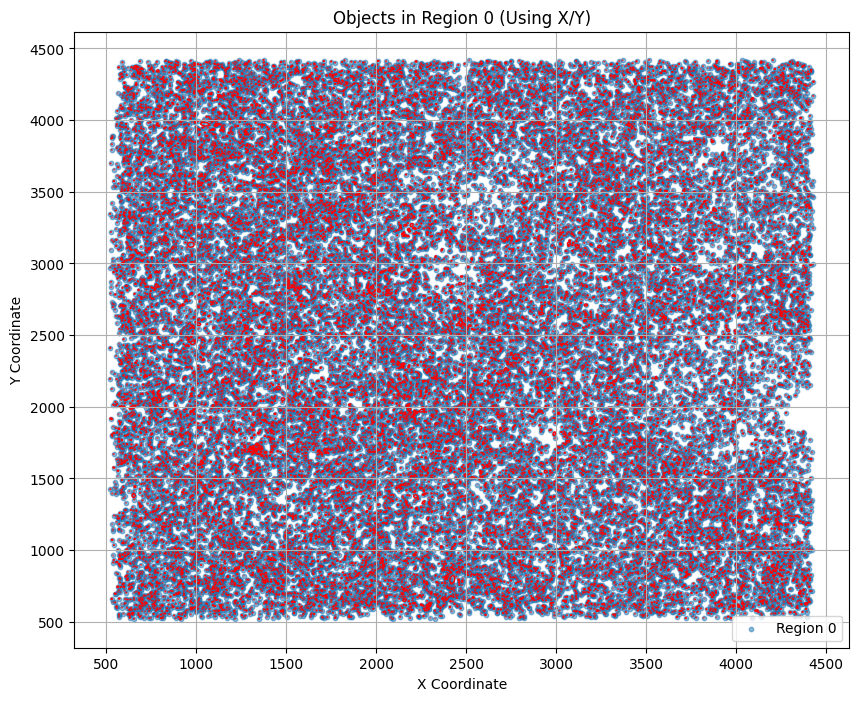

In [7]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.patches import Ellipse
from sklearn.cluster import KMeans
from tqdm import tqdm  # pip install tqdm if not already installed

# 1. Cluster into 8 regions using RA/Dec
kmeans = KMeans(n_clusters=8, random_state=42)
alhambra_df['region'] = kmeans.fit_predict(alhambra_df[['RA', 'Dec']])

# 2. Choose which region to plot (0 through 7)
chosen_region = 0  # example

# 3. Filter the DataFrame to that region only
region_df = alhambra_df[alhambra_df['region'] == chosen_region]

# 4. Plot using x and y
fig, ax = plt.subplots(figsize=(10, 8))

# Scatter the chosen region
ax.scatter(region_df['x'], region_df['y'], s=10, alpha=0.5, label=f'Region {chosen_region}')

# 5. Overlay ellipses with a progress bar
for _, row in tqdm(region_df.iterrows(), total=len(region_df), desc="Plotting ellipses"):
    # If theta is in radians, convert to degrees:
    theta_degrees = np.degrees(row['theta'])

    ellipse = Ellipse(
        xy=(row['x'], row['y']),
        width=2 * row['a'],    # major axis = 2*a
        height=2 * row['b'],   # minor axis = 2*b
        angle=theta_degrees,   # orientation
        edgecolor='red',
        facecolor='none',
        linewidth=1
    )
    ax.add_patch(ellipse)

ax.set_xlabel('X Coordinate')
ax.set_ylabel('Y Coordinate')
ax.set_title(f'Objects in Region {chosen_region} (Using X/Y)')
ax.grid(True)
ax.legend()
plt.show()


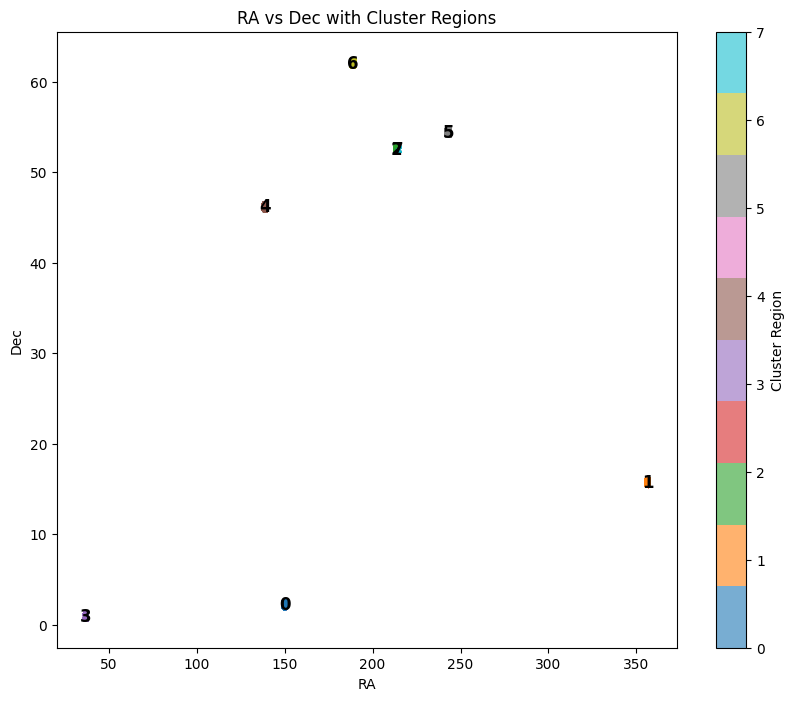

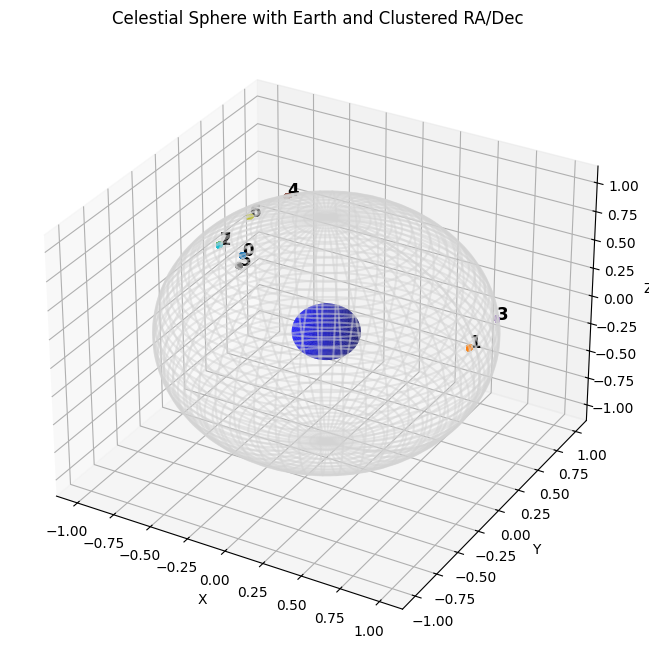

In [8]:
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.mplot3d import Axes3D  # registers the 3D projection
from sklearn.cluster import KMeans

# --- Clustering using RA and Dec ---
# (Assuming alhambra_df is your DataFrame and contains columns 'RA' and 'Dec')
kmeans = KMeans(n_clusters=8, random_state=42)
alhambra_df['region'] = kmeans.fit_predict(alhambra_df[['RA', 'Dec']])
centers = kmeans.cluster_centers_  # shape (8, 2), each row is (RA, Dec) of a cluster center

# --- 1. 2D RA-Dec Plot with Cluster Labels ---
plt.figure(figsize=(10, 8))
scatter = plt.scatter(alhambra_df['RA'], alhambra_df['Dec'], 
                      c=alhambra_df['region'], cmap='tab10', s=5, alpha=0.6)
plt.xlabel("RA")
plt.ylabel("Dec")
plt.title("RA vs Dec with Cluster Regions")

# Annotate cluster centers with their region number
for i, center in enumerate(centers):
    plt.text(center[0], center[1], f"{i}", fontsize=12, fontweight='bold',
             color='black', ha='center', va='center')

plt.colorbar(scatter, label="Cluster Region")
plt.show()

# --- 2. 3D Celestial Sphere Plot ---
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Create a wireframe representing the celestial sphere (unit sphere)
u = np.linspace(0, 2 * np.pi, 100)
v = np.linspace(0, np.pi, 100)
x_sphere = np.outer(np.cos(u), np.sin(v))
y_sphere = np.outer(np.sin(u), np.sin(v))
z_sphere = np.outer(np.ones_like(u), np.cos(v))
ax.plot_wireframe(x_sphere, y_sphere, z_sphere, color='lightgray', alpha=0.5)

# Draw the Earth as a blue sphere at the center
r_earth = 0.2  # arbitrary scale for Earth relative to the celestial sphere
u_earth = np.linspace(0, 2 * np.pi, 50)
v_earth = np.linspace(0, np.pi, 50)
x_earth = r_earth * np.outer(np.cos(u_earth), np.sin(v_earth))
y_earth = r_earth * np.outer(np.sin(u_earth), np.sin(v_earth))
z_earth = r_earth * np.outer(np.ones_like(u_earth), np.cos(v_earth))
ax.plot_surface(x_earth, y_earth, z_earth, color='blue', alpha=0.6)

# Helper function: Convert RA, Dec (degrees) to Cartesian coordinates on a unit sphere.
def radec_to_cartesian(ra, dec):
    ra_rad = np.radians(ra)
    dec_rad = np.radians(dec)
    # x = cos(dec)*cos(ra), y = cos(dec)*sin(ra), z = sin(dec)
    x = np.cos(dec_rad) * np.cos(ra_rad)
    y = np.cos(dec_rad) * np.sin(ra_rad)
    z = np.sin(dec_rad)
    return x, y, z

# Convert all points from RA, Dec to 3D Cartesian coordinates.
x_pts, y_pts, z_pts = radec_to_cartesian(alhambra_df['RA'].values, alhambra_df['Dec'].values)
sc = ax.scatter(x_pts, y_pts, z_pts, c=alhambra_df['region'], cmap='tab10', s=5, alpha=0.6)

# Convert and annotate cluster centers on the sphere.
for i, center in enumerate(centers):
    x_c, y_c, z_c = radec_to_cartesian(center[0], center[1])
    ax.text(x_c, y_c, z_c, f"{i}", fontsize=12, fontweight='bold', color='black')

ax.set_title("Celestial Sphere with Earth and Clustered RA/Dec")
ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Z")
plt.show()


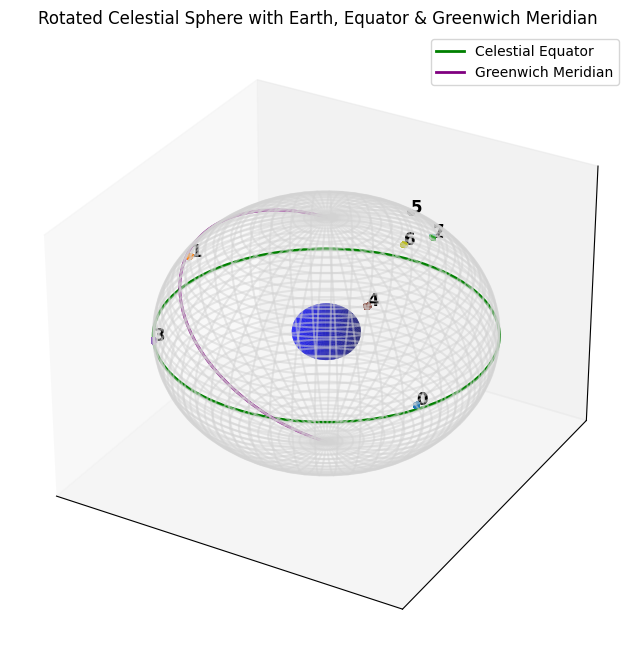

In [15]:
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.mplot3d import Axes3D  # registers the 3D projection
from sklearn.cluster import KMeans

# --- Clustering using RA and Dec ---
kmeans = KMeans(n_clusters=8, random_state=42)
alhambra_df['region'] = kmeans.fit_predict(alhambra_df[['RA', 'Dec']])
centers = kmeans.cluster_centers_  # (8, 2)

# Helper function: Convert RA, Dec (in degrees) to Cartesian coordinates on a unit sphere.
def radec_to_cartesian(ra, dec):
    ra_rad = np.radians(ra)
    dec_rad = np.radians(dec)
    x = np.cos(dec_rad) * np.cos(ra_rad)
    y = np.cos(dec_rad) * np.sin(ra_rad)
    z = np.sin(dec_rad)
    return x, y, z

# Helper function: Rotate points 180° about the z-axis.
# For a 180° rotation, x' = -x, y' = -y, z' = z.
def rotate_z180(x, y, z):
    return -x, -y, z

# --- 3D Celestial Sphere Plot with Reference Lines and Rotated Coordinates ---
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Create and rotate the wireframe of the celestial sphere (unit sphere)
u = np.linspace(0, 2 * np.pi, 100)
v = np.linspace(0, np.pi, 100)
x_sphere = np.outer(np.cos(u), np.sin(v))
y_sphere = np.outer(np.sin(u), np.sin(v))
z_sphere = np.outer(np.ones_like(u), np.cos(v))
# Rotate sphere coordinates
x_sphere, y_sphere, z_sphere = rotate_z180(x_sphere, y_sphere, z_sphere)
ax.plot_wireframe(x_sphere, y_sphere, z_sphere, color='lightgray', alpha=0.5)

# Draw the Earth as a blue sphere at the center (and rotate its coordinates)
r_earth = 0.2  # arbitrary scale for Earth
u_earth = np.linspace(0, 2 * np.pi, 50)
v_earth = np.linspace(0, np.pi, 50)
x_earth = r_earth * np.outer(np.cos(u_earth), np.sin(v_earth))
y_earth = r_earth * np.outer(np.sin(u_earth), np.sin(v_earth))
z_earth = r_earth * np.outer(np.ones_like(u_earth), np.cos(v_earth))
x_earth, y_earth, z_earth = rotate_z180(x_earth, y_earth, z_earth)
ax.plot_surface(x_earth, y_earth, z_earth, color='blue', alpha=0.6)

# Convert and rotate celestial points (from RA, Dec) to 3D Cartesian coordinates.
x_pts, y_pts, z_pts = radec_to_cartesian(alhambra_df['RA'].values, alhambra_df['Dec'].values)
x_pts, y_pts, z_pts = rotate_z180(x_pts, y_pts, z_pts)
sc = ax.scatter(x_pts, y_pts, z_pts, c=alhambra_df['region'], cmap='tab10', s=5, alpha=0.6)

# Annotate cluster centers on the sphere (convert and rotate them)
for i, center in enumerate(centers):
    x_c, y_c, z_c = radec_to_cartesian(center[0], center[1])
    x_c, y_c, z_c = rotate_z180(x_c, y_c, z_c)
    ax.text(x_c, y_c, z_c, f"{i}", fontsize=12, fontweight='bold', color='black')

# --- Add Reference Lines ---

# Celestial Equator: Dec = 0°, RA from 0° to 360°
ra_equator = np.linspace(0, 360, 200)
dec_equator = np.zeros_like(ra_equator)
x_eq, y_eq, z_eq = radec_to_cartesian(ra_equator, dec_equator)
x_eq, y_eq, z_eq = rotate_z180(x_eq, y_eq, z_eq)
ax.plot(x_eq, y_eq, z_eq, color='green', linewidth=2, label='Celestial Equator')

# Greenwich Meridian: RA = 0°, Dec from -90° to 90°
dec_meridian = np.linspace(-90, 90, 200)
ra_meridian = np.zeros_like(dec_meridian)
x_gm, y_gm, z_gm = radec_to_cartesian(ra_meridian, dec_meridian)
x_gm, y_gm, z_gm = rotate_z180(x_gm, y_gm, z_gm)
ax.plot(x_gm, y_gm, z_gm, color='purple', linewidth=2, label='Greenwich Meridian')

# Remove axis numbering (ticks and tick labels)
ax.set_xticks([])
ax.set_yticks([])
ax.set_zticks([])

# Set title (and remove axis labels for a cleaner look)
ax.set_title("Rotated Celestial Sphere with Earth, Equator & Greenwich Meridian")

plt.legend()
plt.show()


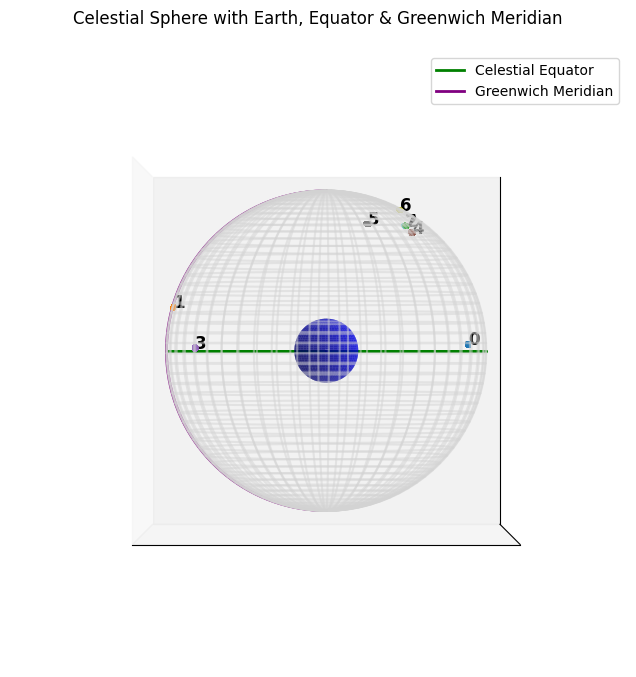

In [18]:
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.mplot3d import Axes3D  # registers the 3D projection
from sklearn.cluster import KMeans

# ------------------------------------------------
# 1) CLUSTERING (if needed)
# ------------------------------------------------
kmeans = KMeans(n_clusters=8, random_state=42)
alhambra_df['region'] = kmeans.fit_predict(alhambra_df[['RA', 'Dec']])
centers = kmeans.cluster_centers_  # shape (8, 2) -> (RA_center, Dec_center)

# ------------------------------------------------
# 2) HELPER: RA,Dec -> Cartesian (unit sphere)
# ------------------------------------------------
def radec_to_cartesian(ra_deg, dec_deg):
    """
    Convert RA,Dec in degrees to x,y,z on the unit sphere.
    Standard formula:
      x = cos(dec)*cos(ra)
      y = cos(dec)*sin(ra)
      z = sin(dec)
    """
    ra_rad = np.radians(ra_deg)
    dec_rad = np.radians(dec_deg)
    x = np.cos(dec_rad) * np.cos(ra_rad)
    y = np.cos(dec_rad) * np.sin(ra_rad)
    z = np.sin(dec_rad)
    return x, y, z

# ------------------------------------------------
# 3) CREATE THE FIGURE & 3D AXIS
# ------------------------------------------------
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Force equal aspect so the sphere isn't distorted
ax.set_box_aspect((1, 1, 1))

# ------------------------------------------------
# 4) DRAW THE CELESTIAL SPHERE (WIREFRAME)
# ------------------------------------------------
u = np.linspace(0, 2 * np.pi, 100)
v = np.linspace(0, np.pi, 100)
x_sphere = np.outer(np.cos(u), np.sin(v))
y_sphere = np.outer(np.sin(u), np.sin(v))
z_sphere = np.outer(np.ones_like(u), np.cos(v))
ax.plot_wireframe(x_sphere, y_sphere, z_sphere, color='lightgray', alpha=0.5)

# ------------------------------------------------
# 5) DRAW EARTH AS A SMALL SPHERE AT CENTER
# ------------------------------------------------
r_earth = 0.2  # arbitrary scale
u_earth = np.linspace(0, 2 * np.pi, 50)
v_earth = np.linspace(0, np.pi, 50)
x_earth = r_earth * np.outer(np.cos(u_earth), np.sin(v_earth))
y_earth = r_earth * np.outer(np.sin(u_earth), np.sin(v_earth))
z_earth = r_earth * np.outer(np.ones_like(u_earth), np.cos(v_earth))
ax.plot_surface(x_earth, y_earth, z_earth, color='blue', alpha=0.6)

# ------------------------------------------------
# 6) PLOT POINTS (CLUSTERS) ON THE SPHERE
# ------------------------------------------------
x_pts, y_pts, z_pts = radec_to_cartesian(alhambra_df['RA'].values, alhambra_df['Dec'].values)
sc = ax.scatter(x_pts, y_pts, z_pts, c=alhambra_df['region'], cmap='tab10', s=5, alpha=0.6)

# Annotate cluster centers
for i, center in enumerate(centers):
    x_c, y_c, z_c = radec_to_cartesian(center[0], center[1])
    ax.text(x_c, y_c, z_c, f"{i}", fontsize=12, fontweight='bold', color='black')

# ------------------------------------------------
# 7) ADD REFERENCE LINES (EQUATOR, GREENWICH)
# ------------------------------------------------

# Celestial Equator: Dec = 0°, RA in [0, 360]
ra_equator = np.linspace(0, 360, 300)
dec_equator = np.zeros_like(ra_equator)
x_eq, y_eq, z_eq = radec_to_cartesian(ra_equator, dec_equator)
ax.plot(x_eq, y_eq, z_eq, color='green', linewidth=2, label='Celestial Equator')

# Greenwich Meridian: RA = 0°, Dec in [-90, +90]
dec_meridian = np.linspace(-90, 90, 300)
ra_meridian = np.zeros_like(dec_meridian)  # RA=0
x_gm, y_gm, z_gm = radec_to_cartesian(ra_meridian, dec_meridian)
ax.plot(x_gm, y_gm, z_gm, color='purple', linewidth=2, label='Greenwich Meridian')

# ------------------------------------------------
# 8) ADJUST VIEW & CLEAN UP AXIS
# ------------------------------------------------

# Make the equator appear horizontal & RA=0 in front
# (Try changing these if you want a slightly different perspective)
ax.view_init(elev=0, azim=90)

# Remove axis ticks and labels for a cleaner look
ax.set_xticks([])
ax.set_yticks([])
ax.set_zticks([])
ax.set_xlabel("")
ax.set_ylabel("")
ax.set_zlabel("")

ax.set_title("Celestial Sphere with Earth, Equator & Greenwich Meridian", pad=20)
ax.legend()
plt.show()


### Understanding ALHAMBRA

### Object Identification & Astrometry

- **#ID**  
  • **What it is:** A unique identifier assigned to each detection.  
  • **How it’s obtained:** The ID is constructed by concatenating several pieces of information (the detection image identifier, the field number, the pointing number, the CCD number, and the sequential ColorPro object number).  
  • **What it tells us:** It uniquely labels an object and encodes its origin (which field, pointing, and detector it comes from), useful for cross-matching and tracking.

- **RA, Dec**  
  • **What they are:** The Right Ascension and Declination (J2000) of the object in decimal degrees.  
  • **How they’re measured:** Derived from the astrometric solution applied to the synthetic F814W detection images. The solution is calibrated using reference catalogs and refined during the data reduction process.  
  • **What they tell us:** They locate the object on the sky, essential for cross-identification with other surveys and for studying spatial distributions.

- **x, y**  
  • **What they are:** Pixel coordinates of the object on the detection image.  
  • **How they’re obtained:** Determined by SExtractor on the F814W image where the source was detected.  
  • **What they tell us:** They provide the object’s position in the image frame and are useful for internal image processing and matching between images.

- **area**  
  • **What it is:** The isophotal aperture area (in pixels) assigned to the object.  
  • **How it’s computed:** Derived from the segmentation map produced by SExtractor, it represents the number of connected pixels above a set threshold.  
  • **What it tells us:** It indicates the extent of the object as seen in the detection image and is useful for flux measurements and for distinguishing extended sources from point sources.

---

### Morphological & Shape Parameters

- **fwhm**  
  • **What it is:** The full width at half maximum (in arcseconds) of the object’s light profile.  
  • **How it’s measured:** Estimated by SExtractor (or via PSF modeling routines) from the object’s brightness distribution, sometimes cross-checked with PSF models generated (e.g. using DAOPHOT).  
  • **What it tells us:** It is a measure of the object’s apparent size and is key in distinguishing unresolved (stellar-like) sources from extended (galaxy) sources.

- **stell**  
  • **What it is:** SExtractor’s “stellarity” index, a value ranging from 0 to 1.  
  • **How it’s computed:** Based on a neural-network algorithm that analyzes the object’s shape and light profile relative to the PSF.  
  • **What it tells us:** Values close to 1 indicate point‐like objects (likely stars), whereas values near 0 point to extended objects (galaxies).

- **ell**  
  • **What it is:** The ellipticity of the object, defined as 1 – (b/a).  
  • **How it’s measured:** Derived from the second-order moments of the light distribution measured by SExtractor.  
  • **What it tells us:** It quantifies how elongated an object is; 0 means perfectly round, while higher values indicate more elongated shapes.

- **a, b**  
  • **What they are:** The RMS of the light distribution along the major axis (a) and the minor axis (b), measured in pixels.  
  • **How they’re computed:** Calculated from the spatial light profile of the object using moment analysis.  
  • **What they tell us:** They provide further quantitative shape information, useful for understanding the object’s size and for correcting aperture effects.

- **theta**  
  • **What it is:** The position angle of the object’s major axis (in degrees, measured counterclockwise from the x‑axis).  
  • **How it’s measured:** Determined from the orientation of the second moments computed by SExtractor.  
  • **What it tells us:** It indicates the orientation of the object on the sky, which can be useful in studies of galaxy alignment or morphology.

---

### Aperture & Photometric Measurement Parameters

- **rk (Kron radius)**  
  • **What it is:** The Kron aperture radius (in pixels) used to measure total flux.  
  • **How it’s computed:** SExtractor computes this radius based on the first moment of the light distribution. ColorPro then applies corrections based on PSF differences between filters.  
  • **What it tells us:** It is used to estimate the total magnitude of the object while accounting for the light falling outside the isophotal aperture.

- **rf (Fraction-of-light radius)**  
  • **What it is:** The radius within which a specified fraction (often 50%) of the total light is enclosed (measured in pixels).  
  • **How it’s measured:** Determined from the cumulative light profile of the object.  
  • **What it tells us:** It provides a characteristic scale of the object’s light distribution, useful in morphological classification.

- **s2n (Signal-to-Noise ratio)**  
  • **What it is:** The ratio of the measured flux (typically SExtractor’s FLUX_AUTO) to its uncertainty.  
  • **How it’s computed:** Calculated directly from the flux and its error as provided by SExtractor, often after applying PSF corrections.  
  • **What it tells us:** It indicates the quality of the photometric measurement; higher values mean more reliable flux estimates.

- **photoflag**  
  • **What it is:** A flag from SExtractor indicating potential photometric issues (e.g. blending, saturation, truncation).  
  • **How it’s obtained:** Automatically assigned by SExtractor during source extraction based on various criteria.  
  • **What it tells us:** It helps in filtering out objects with problematic photometry when performing further analysis.

---

### Filter Photometry (Optical & NIR)

For each of the ALHAMBRA filters, two columns are provided: one for the total magnitude and one for its uncertainty.

- **Optical Filters (F365W, F396W, F427W, F458W, F489W, F520W, F551W, F582W, F613W, F644W, F675W, F706W, F737W, F768W, F799W, F830W, F861W, F892W, F923W, F954W)**  
  • **How they are measured:**  
    - **Detection & PSF Correction:** The flux in each filter is measured within apertures defined on the deep synthetic F814W detection image. ColorPro is used to compute PSF-corrected magnitudes, ensuring that differences in image quality (seeing, PSF shape) across filters do not bias the colors.  
    - **Error Estimation:** The uncertainties (dFxxxW) are estimated from the background noise. These errors are further refined by an empirical re-estimation process that accounts for correlated noise (see “irms” columns below).  
  • **What they tell us:** They provide the spectral energy distribution (SED) of the object across 20 medium-band optical filters, essential for deriving accurate photometric redshifts and spectral classifications.

- **Near-Infrared (NIR) Filters (J, H, KS)**  
  • **How they are measured:**  
    - Derived from Omega-2000 NIR images which are PSF-matched and calibrated (using the 2MASS catalog).  
    - The fluxes are measured similarly to the optical bands with appropriate adjustments for the NIR data characteristics.  
  • **What they tell us:** They extend the SED into the NIR regime, which is critical for breaking degeneracies in the photo‑z estimation and for understanding stellar populations.

- **F814W and its Variants**  
  • **F814W, dF814W:**  
    - **How measured:** This is a synthetic detection image created by combining several of the best optical bands. The F814W magnitude is measured on this deep image and serves as the primary detection band.  
    - **What it tells us:** It provides a high signal-to-noise reference magnitude used for source detection and for defining consistent apertures across the survey.
  • **F814W_3arcs, dF814W_3arcs:**  
    - **How measured:** The flux is measured within a fixed circular aperture of 3 arcseconds on the F814W image.  
    - **What it tells us:** These measurements are useful for comparing with external datasets (e.g. COSMOS) and for cases where a fixed aperture provides a better estimate of color.
  • **F814W_3arcs_corr:**  
    - **How obtained:** A correction (often magnitude-dependent) is applied to the 3″ aperture magnitude to account for light losses and PSF effects, calibrated to match external standards.
    - **What it tells us:** It gives a more accurate magnitude for comparisons and for SED fitting.

---

### Detection & Quality Flags

- **nfobs**  
  • **What it is:** The number of filters (out of 24) in which the object was successfully detected.  
  • **How it’s computed:** It is determined by checking in how many bands the object’s flux exceeds the detection threshold.  
  • **What it tells us:** It provides a measure of the completeness of the SED – objects detected in more bands have a better-defined SED and more reliable photometric redshifts.

- **xray**  
  • **What it is:** A flag indicating whether the source is associated with an X-ray detection (from catalogs like 2XMM).  
  • **How it’s obtained:** By cross-matching the ALHAMBRA positions with X-ray source catalogs.  
  • **What it tells us:** It may help to identify active galactic nuclei (AGN) or other high-energy phenomena.

- **PercW (Percentual Photometric Weight)**  
  • **What it is:** A measure of the effective exposure or weight for the object in the detection image.  
  • **How it’s computed:** Derived from the weight maps generated during data reduction that account for variations in exposure time across the image.  
  • **What it tells us:** It indicates the reliability of the photometry; lower weights can signal areas with higher uncertainties.

- **Satur_Flag**  
  • **What it is:** A flag that identifies potentially saturated detections.  
  • **How it’s determined:** Based on thresholds (for instance, objects brighter than a given magnitude, e.g., mF814W < 16, or those with high pixel counts) as flagged by SExtractor.  
  • **What it tells us:** It warns that the photometry of these objects may be unreliable due to saturation.

- **Stellar_Flag**  
  • **What it is:** A statistical classifier (ranging from 0 to 1) that indicates the probability that an object is a star (1) versus a galaxy (0).  
  • **How it’s computed:** Combining information from morphology (FWHM, shape parameters), the F814W magnitude, and colors (optical and NIR color indices such as F489W–F814W and J–Ks) to build empirical probability distribution functions (PDFs) for stars and galaxies.  
  • **What it tells us:** It is used to separate stars from galaxies, which is essential for extragalactic studies.

---

### Photometric Redshift and SED-Fitting Parameters (from BPZ)

- **zb_1**  
  • **What it is:** The most likely (Bayesian) photometric redshift estimated by BPZ.  
  • **How it’s obtained:** BPZ compares the observed multi-band SED (after PSF correction and calibration) with a library of galaxy templates, weighted by an empirically derived prior based on the F814W magnitude.  
  • **What it tells us:** It provides an estimate of the object’s distance (redshift) and is crucial for studies of galaxy evolution.

- **zb_Min_1, zb_Max_1**  
  • **What they are:** The lower and upper bounds of the confidence interval (often the 68% or 95% interval) around the Bayesian redshift.  
  • **How they’re computed:** By integrating the full redshift probability distribution function, p(z), until a specified confidence level is reached.  
  • **What they tell us:** They quantify the uncertainty in the photometric redshift estimate.

- **Tb_1**  
  • **What it is:** The most likely spectral type (or template index) assigned by BPZ.  
  • **How it’s obtained:** Based on which template best reproduces the observed SED, taking into account both the likelihood and the prior.  
  • **What it tells us:** It indicates the galaxy’s type (e.g., elliptical, spiral, starburst) and is used for further analysis such as stellar mass estimation.

- **Odds_1**  
  • **What it is:** The “odds” parameter from BPZ, representing the fraction of the total p(z) contained within a narrow interval around the peak redshift.  
  • **How it’s computed:** By summing the p(z) probability in a fixed window (often ±0.0125×(1+z)) around zb_1.  
  • **What it tells us:** It reflects the reliability or unambiguity of the redshift estimate; higher odds mean a more sharply peaked p(z).

- **z_ml, t_ml**  
  • **What they are:** The maximum likelihood estimates for redshift and spectral type, respectively.  
  • **How they’re computed:** By directly maximizing the likelihood function (without the influence of the prior).  
  • **What they tell us:** They serve as an alternative estimate and can be compared with the Bayesian values to assess the impact of the prior.

- **Chi2**  
  • **What it is:** The reduced chi-squared value from the SED fitting.  
  • **How it’s obtained:** By comparing the observed fluxes (with errors) to the fluxes predicted by the best-fitting template across all filters.  
  • **What it tells us:** It indicates the quality of the fit; values significantly above 1 may indicate a poor fit or unmodeled complexities (such as AGN activity).

- **Stell_Mass_1**  
  • **What it is:** The estimated stellar mass (usually in log₁₀ M⊙) derived from the best-fit SED.  
  • **How it’s computed:** Using a color–mass-to-light (M/L) ratio relationship (e.g., from Taylor et al. 2011) applied to the BPZ template’s fluxes.  
  • **What it tells us:** It provides an estimate of the galaxy’s stellar mass, important for studies of galaxy evolution and mass functions.

- **M_Abs_1**  
  • **What it is:** The absolute magnitude in the Johnson B-band (on the AB system).  
  • **How it’s obtained:** By converting the observed flux using the best-fit redshift and applying k-corrections derived from the SED.  
  • **What it tells us:** It gives a measure of the intrinsic luminosity of the galaxy.

- **MagPrior**  
  • **What it is:** The F814W magnitude used to construct the BPZ prior.  
  • **How it’s obtained:** It is simply the observed F814W magnitude that serves as an input to the prior probability function in BPZ.  
  • **What it tells us:** It helps to weight the redshift probability distribution based on the expected redshift–magnitude relation.

---

### Empirically Re-estimated Photometric Uncertainties (“irms”) and Quality Flags

For each band, there is a re-estimated RMS value and associated quality flags:

- **irms_F365W, irms_F396W, …, irms_F954W**  
  • **What they are:** Empirically determined uncertainties for each optical filter.  
  • **How they’re computed:** By placing thousands of apertures on blank regions of each image (using the weight maps to account for exposure variations) to measure the background RMS and accounting for pixel-to-pixel correlations introduced during processing.  
  • **What they tell us:** They provide more realistic error estimates than those from SExtractor alone, crucial for accurate SED fitting and redshift determination.

- **irms_J, irms_H, irms_KS**  
  • **What they are:** The empirical uncertainties for the NIR J, H, and Ks bands, computed in a similar fashion as for the optical bands.  
  • **What they tell us:** They help assess the reliability of the NIR flux measurements.

- **irms_F814W**  
  • **What it is:** The re-estimated uncertainty for the synthetic F814W detection image.  
  • **How it’s obtained:** Via the same empirical noise estimation method, adjusted for the combined nature of the detection image.

- **irms_OPT_Flag, irms_NIR_Flag**  
  • **What they are:** Flags indicating the quality of the photometry for the optical and NIR images respectively.  
  • **How they’re computed:** They count the number of bands where the normalized exposure (from the weight maps) is below 80% of the maximum.  
  • **What they tell us:** They flag sources that might have unreliable photometry in a significant fraction of filters due to lower effective exposure times.

---

### Summary

Each column in the catalog is the result of a carefully designed process:
- **Detection and geometry** are defined on a deep, synthetic F814W image.
- **PSF-corrected photometry** is performed using ColorPro to ensure that differences in seeing and PSF do not bias the measured colors.
- **Empirical noise estimation** (the “irms” values) corrects the underestimation of errors typical of simple Poisson models.
- **SED fitting and photometric redshift estimation** are carried out with BPZ, which uses a library of calibrated templates and an empirically derived prior to yield robust redshift, spectral type, and stellar mass estimates.

Together, these columns provide a comprehensive dataset that characterizes the position, shape, flux, color, and redshift-related properties of hundreds of thousands of galaxies and stars across the ALHAMBRA survey area. This level of detail is what enables precise studies of galaxy evolution and the large-scale structure of the universe.  
citeturn7file4

## Plots alhambra


FWHM Histogram:
The code creates a histogram of the “fwhm” column (after dropping missing values) with 30 bins. This visualizes the distribution of seeing conditions, similar to Figure 5 in the paper.

Photometric Redshift Distribution:
Two subsamples are created based on the synthetic F814W magnitude (using cuts at 22.5 and 24.5). Histograms of the photometric redshift (from “zb_1”) are then overlaid, allowing you to see how the redshift distribution changes with depth.

Color–Color Diagram:
Colors are computed by subtracting the magnitudes: (F489W – F814W) for the optical and (J – KS) for the NIR. A scatter plot is then created, which can help in distinguishing stars from galaxies based on their typical color loci.

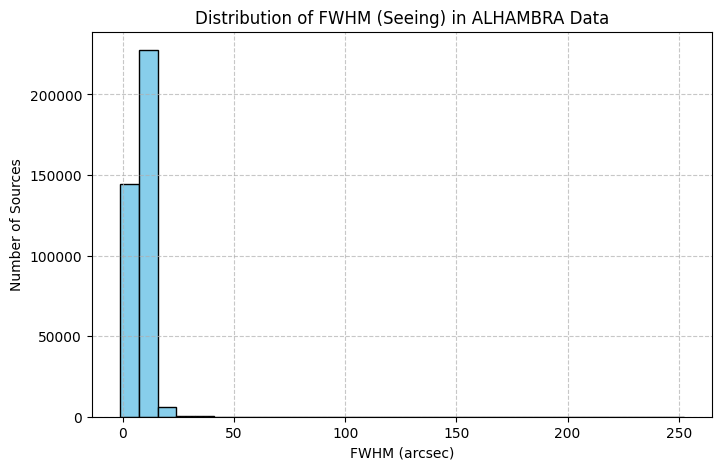

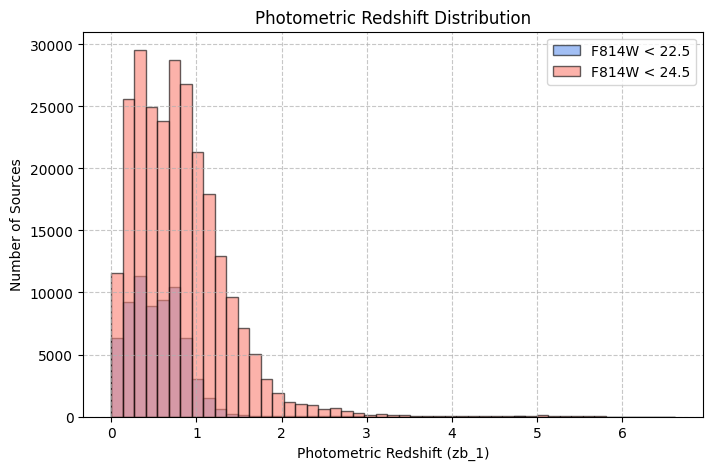

In [19]:
import matplotlib.pyplot as plt
import numpy as np

# 1. Plot: Distribution of FWHM (Seeing Conditions)
plt.figure(figsize=(8, 5))
plt.hist(alhambra_df['fwhm'].dropna(), bins=30, color='skyblue', edgecolor='black')
plt.xlabel('FWHM (arcsec)')
plt.ylabel('Number of Sources')
plt.title('Distribution of FWHM (Seeing) in ALHAMBRA Data')
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

# 2. Plot: Photometric Redshift Distribution with Magnitude Cuts
# Define magnitude cuts using the synthetic F814W column
mag_cut1 = 22.5
mag_cut2 = 24.5

# Select sources based on F814W magnitude
df_cut1 = alhambra_df[alhambra_df['F814W'] < mag_cut1]
df_cut2 = alhambra_df[alhambra_df['F814W'] < mag_cut2]

plt.figure(figsize=(8, 5))
bins = np.linspace(0, np.max(alhambra_df['zb_1'].dropna()), 50)
plt.hist(df_cut1['zb_1'].dropna(), bins=bins, alpha=0.6, label=f'F814W < {mag_cut1}', color='cornflowerblue', edgecolor='black')
plt.hist(df_cut2['zb_1'].dropna(), bins=bins, alpha=0.6, label=f'F814W < {mag_cut2}', color='salmon', edgecolor='black')
plt.xlabel('Photometric Redshift (zb_1)')
plt.ylabel('Number of Sources')
plt.title('Photometric Redshift Distribution')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

# 3. Plot: Color-Color Diagram for Star/Galaxy Separation
# Compute the colors: Optical color = F489W - F814W, NIR color = J - KS.
# (Make sure to drop any NaN values to avoid issues.)
# color_optical = alhambra_df['F489W'] - alhambra_df['F814W']
# color_nir = alhambra_df['J'] - alhambra_df['KS']

# plt.figure(figsize=(8, 6))
# plt.scatter(color_optical, color_nir, s=10, alpha=0.7, color='mediumseagreen', edgecolor='none')
# plt.xlabel('F489W - F814W')
# plt.ylabel('J - KS')
# plt.title('Color-Color Diagram: Optical vs. NIR')
# plt.grid(True, linestyle='--', alpha=0.7)
# plt.show()


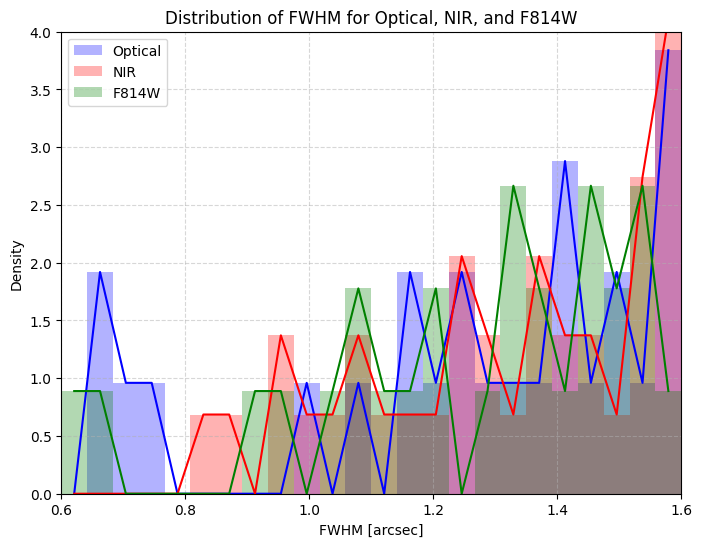

In [3]:
import numpy as np
import matplotlib.pyplot as plt

# -----------------------------
# 1) Get F814W FWHM values from the dataframe
# -----------------------------
# Assume 'fwhm' in alhambra_df corresponds to the synthetic F814W detection image.
fwhm_f814w = alhambra_df['fwhm'].dropna()

# -----------------------------
# 2) Simulate Optical and NIR FWHM distributions
# -----------------------------
# We assume:
# - Optical images have a slightly larger PSF (~1.1 arcsec median): add +0.1 arcsec.
# - NIR images have a slightly smaller PSF (~0.9 arcsec median): subtract 0.1 arcsec.
fwhm_optical = fwhm_f814w + 0.1
fwhm_nir     = fwhm_f814w - 0.1

# -----------------------------
# 3) Define bins for the histogram
# -----------------------------
bins = np.linspace(0.6, 1.6, 25)  # adjust if needed

# -----------------------------
# 4) Create the figure and plot histograms with overlaid lines
# -----------------------------
plt.figure(figsize=(8,6))

# Optical Histogram & Line Plot
counts_opt, edges_opt = np.histogram(fwhm_optical, bins=bins, density=True)
centers_opt = 0.5 * (edges_opt[:-1] + edges_opt[1:])
plt.hist(fwhm_optical, bins=bins, density=True, alpha=0.3, color='blue', label='Optical')
plt.plot(centers_opt, counts_opt, color='blue')

# NIR Histogram & Line Plot
counts_nir, edges_nir = np.histogram(fwhm_nir, bins=bins, density=True)
centers_nir = 0.5 * (edges_nir[:-1] + edges_nir[1:])
plt.hist(fwhm_nir, bins=bins, density=True, alpha=0.3, color='red', label='NIR')
plt.plot(centers_nir, counts_nir, color='red')

# F814W Histogram & Line Plot
counts_814, edges_814 = np.histogram(fwhm_f814w, bins=bins, density=True)
centers_814 = 0.5 * (edges_814[:-1] + edges_814[1:])
plt.hist(fwhm_f814w, bins=bins, density=True, alpha=0.3, color='green', label='F814W')
plt.plot(centers_814, counts_814, color='green')

# -----------------------------
# 5) Final Plot Formatting
# -----------------------------
plt.xlabel('FWHM [arcsec]')
plt.ylabel('Density')
plt.title('Distribution of FWHM for Optical, NIR, and F814W')
plt.xlim(0.6, 1.6)
plt.ylim(0, 4.0)  # adjust the y-limit if needed
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()


In [9]:
#Separa las columnas
import pandas as pd

# These are the 20 optical filters from F365W through F954W
optical_cols = [
    'F365W', 'F396W', 'F427W', 'F458W', 'F489W',
    'F520W', 'F551W', 'F582W', 'F613W', 'F644W',
    'F675W', 'F706W', 'F737W', 'F768W', 'F799W',
    'F830W', 'F861W', 'F892W', 'F923W', 'F954W'
]

# The three near‐infrared filters
nir_cols = ['J', 'H', 'KS']

# The synthetic detection filter
f814w_col = 'F814W'

# Now, for convenience, you can create separate dataframes if needed:
df_optical = alhambra_df[optical_cols]           # Only optical filters
df_nir     = alhambra_df[nir_cols]               # Only NIR filters
df_f814w   = alhambra_df[[f814w_col]]            # Only the F814W column

#Error columns
optical_err_cols = [f"d{filt}" for filt in optical_cols]
nir_err_cols = [f"d{filt}" for filt in nir_cols]
f814w_err_col = "dF814W"



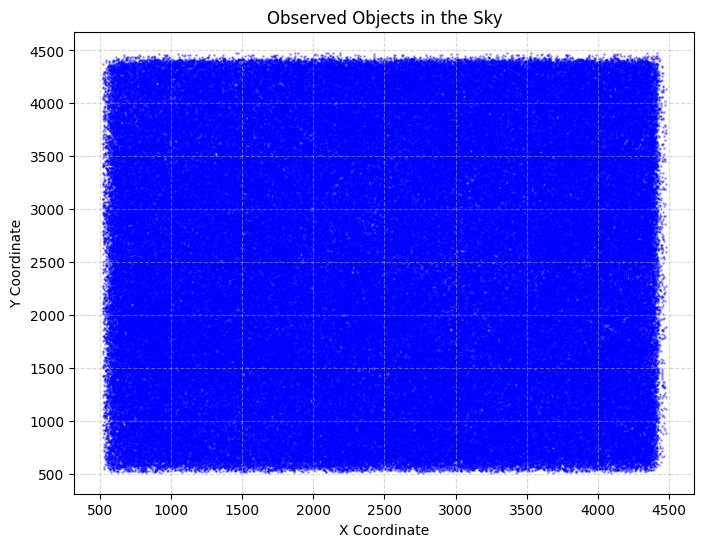

In [7]:
plt.figure(figsize=(8, 6))
plt.scatter(alhambra_df['x'], alhambra_df['y'], s=1, alpha=0.3, c='blue')

plt.xlabel("X Coordinate")
plt.ylabel("Y Coordinate")
plt.title("Observed Objects in the Sky")

plt.grid(True, linestyle="--", alpha=0.5)
plt.show()


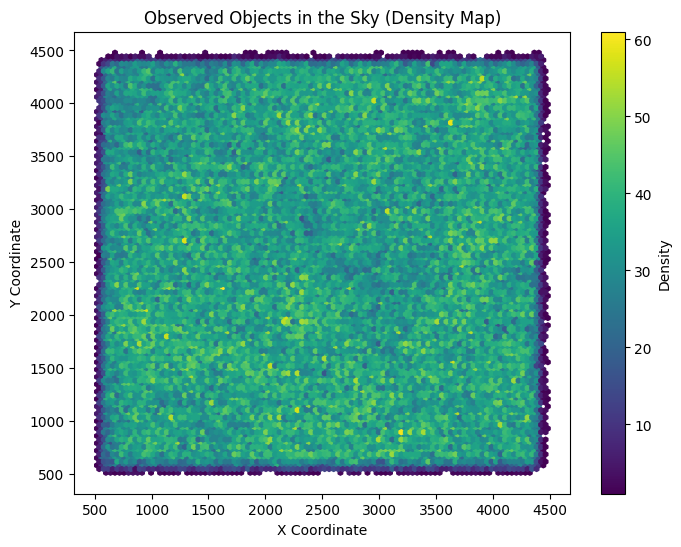

In [5]:
import matplotlib.pyplot as plt

# Set figure size
plt.figure(figsize=(8, 6))

# Use hexbin plot for density visualization
plt.hexbin(alhambra_df['x'], alhambra_df['y'], gridsize=100, cmap='viridis', mincnt=1)

# Labels and title
plt.xlabel("X Coordinate")
plt.ylabel("Y Coordinate")
plt.title("Observed Objects in the Sky (Density Map)")

# Show color bar for density
plt.colorbar(label='Density')

# Show plot
plt.show()


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.patches import Ellipse

# Set figure size
plt.figure(figsize=(8, 6))

# Use hexbin plot for density visualization
plt.hexbin(alhambra_df['x'], alhambra_df['y'], gridsize=100, cmap='viridis', mincnt=1)

# Get the current axes to add patches
ax = plt.gca()

# Loop through each object in the DataFrame
for index, row in alhambra_df.iterrows():
    # Convert theta from radians to degrees (remove np.degrees if theta is already in degrees)
    theta_degrees = np.degrees(row['theta'])
    
    # Create an ellipse patch:
    # - Center at (x, y)
    # - Width = 2*a and Height = 2*b (assuming a and b are semi-axes)
    ellipse = Ellipse((row['x'], row['y']), width=2*row['a'], height=2*row['b'],
                      angle=theta_degrees, edgecolor='red', facecolor='none', linewidth=1)
    
    # Add the ellipse to the plot
    ax.add_patch(ellipse)

# Labels and title
plt.xlabel("X Coordinate")
plt.ylabel("Y Coordinate")
plt.title("Observed Objects in the Sky (Density Map with Elliptical Approximations)")

# Show color bar for density
plt.colorbar(label='Density')

# Display the plot
plt.show()


KeyboardInterrupt: 

Error in callback <function _draw_all_if_interactive at 0x000001ACAA4390D0> (for post_execute), with arguments args (),kwargs {}:


KeyboardInterrupt: 